# Proyek Analisis Data: PRSA
- **Nama:** Putu Indah Ciptayani
- **Email:** putuindah@pnb.ac.id
- **ID Dicoding:** indahcpt

## Menentukan Pertanyaan Bisnis

1. Bagaimana korelasi antar setiap kolom dalam dataset?
2. Bagaimana rata-rata polutan dalam bentuk partikel debu pada setiap stasiun?
3. Bagaimana rata-rata polutan dalam bentuk gas per stasiun pada setiap stasiun?
4. Bagaimana penggolongan polutan dalam bentuk partikel debu pada setiap stasiun?
5. Bagaimana sebaran geografis dari polutan partikel padat?

## Import Semua Packages/Library yang Digunakan

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from geopy.geocoders import Nominatim
import time

import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import MarkerCluster, HeatMap
from IPython.display import display

import streamlit as st
from streamlit_folium import folium_static


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-01-02 19:06:19.060 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Data Wrangling

### Gathering Data

In [10]:
# 1. Menentukan folder tempat file CSV disimpan
folder_path = 'PRSA'  # Gantilah dengan lokasi folder Anda

# 2. Membaca semua file dengan ekstensi .csv di folder tersebut
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 3. Menggabungkan semua file CSV
dataframes = []
for file in all_files:
    file_path = os.path.join(folder_path, file)  # Menggabungkan path folder dan nama file
    df = pd.read_csv(file_path)                 # Membaca setiap file CSV ke dalam dataframe
    dataframes.append(df)                       # Menambahkan dataframe ke dalam list

# 4. Menggabungkan semua dataframe menjadi satu
prsa_df = pd.concat(dataframes, ignore_index=True)

# 5. Opsional: Menyimpan hasil gabungan ke file baru
prsa_df.to_csv('prsa.csv', index=False)  # Gantilah nama file sesuai kebutuhan

# 6. Menampilkan hasil gabungan
prsa_df



,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,27.0,72.0,8.0,92.0,800.0,16.0,10.3,1014.2,-12.4,0.0,W,1.8,Shunyi
420764,35061,2017,2,28,20,47.0,55.0,17.0,86.0,1100.0,19.0,9.8,1014.5,-9.9,0.0,NW,1.5,Shunyi
420765,35062,2017,2,28,21,18.0,28.0,4.0,30.0,500.0,64.0,9.1,1014.6,-12.7,0.0,NE,1.7,Shunyi
420766,35063,2017,2,28,22,18.0,20.0,9.0,33.0,500.0,59.0,7.1,1015.2,-13.2,0.0,WNW,1.8,Shunyi


In [13]:
# mengecek banyaknya stasiun pengamatan data
prsa_df['station'].nunique()

12

**Insight:**

- Data di atas merupakan data kondisi cuaca dan kualitas udara pada 12 stasiun
- Total data cuaca dan kualitas udara harian yang berhasil dicatat adalah sebanyak 420.768 pengamatan
- Terdapat 18 kolom yang dapat dijelaskan sebagai berikut:

Kolom |Deskripsi
-------|---------
No |Nomor urut data
year | Tahun pencatatan
month | Bulan pencatatan (1-12)
day | Tanggal pencatatan (1-31)
hour | Jam pencatatan (0-23)
PM2.5 | Konsentrasi partikel PM2.5 (µg/m³), partikel halus yang berbahaya
PM10 | Konsentrasi partikel PM10 (µg/m³), partikel kasar yang berbahaya
SO2 | Konsentrasi sulfur dioksida (µg/m³)
NO2 | Konsentrasi nitrogen dioksida (µg/m³)
CO | Konsentrasi karbon monoksida (µg/m³)
O3 | Konsentrasi ozon (µg/m³)
TEMP | Suhu udara (°C)
PRES | Tekanan udara (hPa)
DEWP | Titik embun (°C), suhu di mana uap air mulai mengembun
RAIN | Curah hujan (mm)
wd | Arah angin (keterangan arah kompas: N, NE, NW, dll)
WSPM | Kecepatan angin (m/s)
station | Nama stasiun pengamatan



### Assessing Data

In [17]:
# mengecek tipe data
prsa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


In [19]:
# mengecek duplikasi data
print("Jumlah duplikasi: ", prsa_df.duplicated().sum())

Jumlah duplikasi:  0


In [21]:
# mengecek jumlah nan di setiap kolom
missing_count = prsa_df.isnull().sum()

# Menghitung persentase data kosong
missing_percent = (missing_count / len(prsa_df)) * 100

# Membuat DataFrame baru untuk ringkasan
missing_data = pd.DataFrame({
    'Jumlah Kosong': missing_count,
    'Persentase (%)': missing_percent
})

# Menampilkan hanya kolom dengan data kosong
missing_data = missing_data[missing_data['Jumlah Kosong'] > 0]

# Menampilkan hasil
missing_data



,Jumlah Kosong,Persentase (%)
PM2.5,8739,2.076916
PM10,6449,1.532674
SO2,9021,2.143937
NO2,12116,2.879497
CO,20701,4.919813
O3,13277,3.155421
TEMP,398,0.094589
PRES,393,0.093401
DEWP,403,0.095777
RAIN,390,0.092688


In [23]:
# mengecek statistik dasar data
prsa_df.describe()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,10122.116943,1.177198,3.448707,8.800102,6.922195,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


<Figure size 1200x800 with 0 Axes>

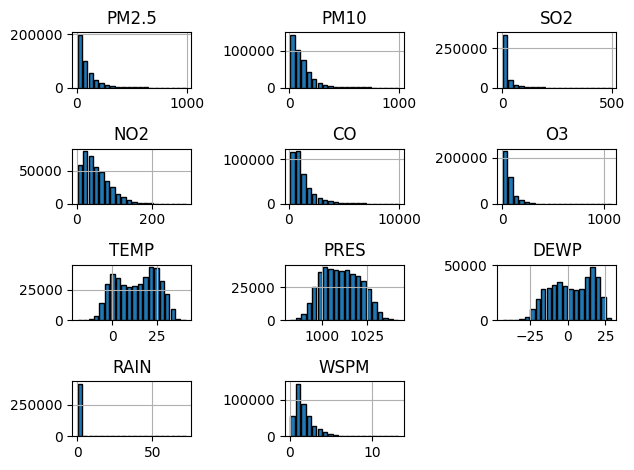

In [25]:
# Mengambil subset data dari kolom ke-5 hingga kolom terakhir
prsa_df_sub = prsa_df.iloc[:, 5:-1]

# Menggambar histogram dengan ukuran yang lebih lebar dan jarak antar bar
plt.figure(figsize=(12, 8))  # Mengatur ukuran gambar (lebih lebar)

# Membuat histogram dengan lebar bar lebih besar dan jarak antar bar
prsa_df_sub.hist(bins=20, edgecolor='black', rwidth=0.8)  # rwidth mengatur jarak antar bar

# Menambahkan judul dan label
plt.title('Histogram untuk Data Subset')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

# Menampilkan plot
plt.tight_layout()
plt.show()

**Insight:**

- Terdapat **18 kolom** data di dalam dataset, yang mana ada 5 kolom bertipe **integer** yaitu No, year, month, day dan hour, 2 kolom bertipe **objek** yaitu wd dan station dan 11 kolom lainnya bertipe data **float**
- Tidak terdapat data duplikat
- Total data yang telah diamati mulai tahun **2013 hingga 2017 adalah sejumlah 420.768** data
- Terdapat 11 kolom yang memiliki nilai kosong (missing value), yaitu: 
    - CO dengan data kosong hampir 5%
    - PM2.5, PM10, SO2, NO2, O3 dengan data kosong antara 1 hingga 4%
    - TEMP, PRES, DEWP, RAIN, wd dan WSPM memiliki data kosong di bawah 0.5%
- Deskripsi statistik menunjukkan adanya kualitas partikel polutan yang cukup ekstrem seperti PM2.5 hingga 999. Namun untuk mengetahui validitas rentang nilai untuk setiap kolom diperlukan ahli di bidangnya, sehingga dalam hal ini data dianggap valid dulu.
- Melihat nilai Q1 dan Q3 pada hasil analisis deskriptif dan didukung oleh histogram, tentu tampak adanya outlier pada beberapa kolom seperti PM2.5, PM10, NO2, CO, O3 (jika dilakukan IQR analysis dan visualisasi boxplot). Namun untuk kali ini kita tidak melakukan analisis outlier
- Histogram menunjukkan data 
    - **NO2, CO, O3, Rain dan WSPM** memiliki tipe **positive skewed** dimana data lebih banyak terdistribusi pada nilai kecil (kiri).
    - **DEWP** memiliki tipe **negative skewed** dimana data lebih banyak terdistribusi pada nilai besar (kanan).
    - **PRES** memiliki tipe **normal**, yang mana dari statistik terlihat juga bahwa mean dan median (Q2) memiliki nilai hampir sama


**Kesimpulan**

1. Tipe Data : **Sesuai**
2. Data Duplikat : **Tidak ada**
3. Data Kosong/Missing Value : **Ada pada 11 kolom dengan jumlah maksimal 5%**
4. Data Tidak Valid : **Tidak ada**

### Cleaning Data

- Sesuai hasil assesment pada data maka perlu dilakukan penanganan data kosong saja.
- Data kosong akan ditangani dengan beberapa pertimbangan berikut:
    1. Data bertipe float dengan distribusi normal (PRES) **diisi dengan mean**
    2. Data bertipe float lainnya yang bertipe skewed **diisi dengan median** karena berdasarkan analisis statistik deskriptif terdapat nilai-nilai esktrem atau outlier
    3. Data bertipe objek yaitu kolom **wd diganti dengan modus**
    4. Penggantian nilai akan menggunakan median dan modus per stasiun (bukan keseluruhan data) agar lebih representatif untuk setiap stasiun


In [28]:
# Mengisi data kosong dengan modus untuk kolom bertipe object dan dengan median untuk kolom numerik
for col in prsa_df.columns:  # Loop melalui semua kolom dalam DataFrame
    if prsa_df[col].isnull().sum() > 0:  # Memeriksa apakah kolom memiliki data kosong
        if col == 'PRES':  # Pengecekan khusus untuk kolom 'PRES'
            prsa_df[col] = prsa_df.groupby('station')[col].transform(lambda x: x.fillna(x.mean()))
        elif prsa_df[col].dtype == 'object':  # Jika kolom bertipe object
            prsa_df[col] = prsa_df.groupby('station')[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else None))
        else:  # Jika kolom bertipe numerik lainnya
            prsa_df[col] = prsa_df.groupby('station')[col].transform(lambda x: x.fillna(x.median()))


In [30]:
# memastikan bahwa data telah terisi semua
prsa_df.isna().sum()

No         0
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

In [31]:
# mengecek statistik dasar data
prsa_df.describe()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,79.273026,104.235659,15.642997,50.384959,1212.909829,56.925748,13.539869,1010.746341,2.491120,0.064416,1.729444
std,10122.116943,1.177198,3.448707,8.800102,6.922195,80.064127,91.123375,21.456742,34.714968,1134.271612,55.830557,11.430772,10.469404,13.787259,0.820626,1.245961
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,21.000000,36.000000,3.000000,23.000000,500.000000,12.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,55.000000,82.000000,7.000000,43.000000,900.000000,44.000000,14.500000,1010.400000,3.000000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,109.000000,144.000000,19.000000,70.000000,1500.000000,80.000000,23.200000,1019.000000,15.100000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


<Figure size 1200x800 with 0 Axes>

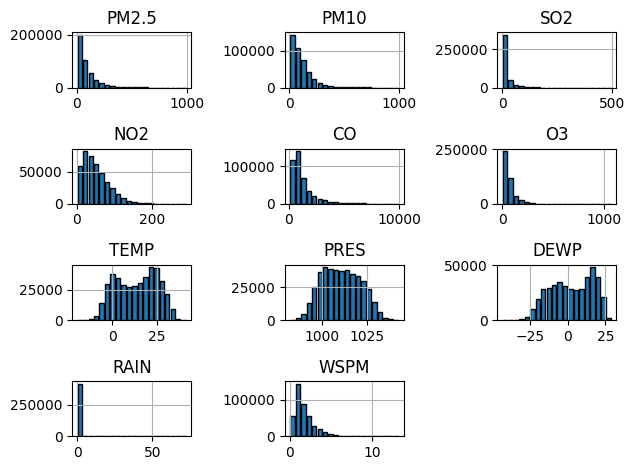

In [32]:
# Mengambil subset data dari kolom ke-5 hingga kolom terakhir
prsa_df_sub = prsa_df.iloc[:, 5:-1]

# Menggambar histogram dengan ukuran yang lebih lebar dan jarak antar bar
plt.figure(figsize=(12, 8))  # Mengatur ukuran gambar (lebih lebar)

# Membuat histogram dengan lebar bar lebih besar dan jarak antar bar
prsa_df_sub.hist(bins=20, edgecolor='black', rwidth=0.8)  # rwidth mengatur jarak antar bar

# Menambahkan judul dan label
plt.title('Histogram untuk Data Subset')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')

# Menampilkan plot
plt.tight_layout()
plt.show()

**Insight:**

- Setelah dilakukan pengisian data kosong dengan median dan modus, semua data telah terisi
- Hal ini akan mempengaruhi distribusi data, namun karena hanya sedikit data kosong (5% atau bahkan kurang), tentu hal ini tidak akan mengubah nilai rerata, standar deviasai, Q1, Q2 dan Q3 secara signifikan.
- Untuk data dengan missing values terbanyak yaitu CO mengalami perubahan nilai rearat dari 1230 turun 18 point menjadi 1212, sedangkan standar deviasi 1160 menjadi 1134 yang menunjukka bahwa data makin seragam.
- Pengisian data pada kolom numerik tidak mempengaruhi nilai terkecil dan terbesar karena dalam hal ini digunakan median
- Histogram menunjukkan bahwa sebaran data tidak mengalami perubahan sebelum dan sesudah pengisian data kosong, karena memang perubahan data bersifat minor (hanya 5% atau kurang)

## Exploratory Data Analysis (EDA)

### 1. Mengetahui Korelasi Antar Kolom Numerik

In [40]:
prsa_df_sub = prsa_df.iloc[:, 5:-1]

# Memilih hanya kolom dengan tipe data numerik
prsa_df_sub_numeric = prsa_df_sub.select_dtypes(include=['number'])

# Menghitung korelasi antar kolom numerik
correlation_matrix = prsa_df_sub_numeric.corr()

correlation_matrix

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000000,0.879385,0.478184,0.659287,0.767196,-0.148275,-0.130859,0.019548,0.112713,-0.014307,-0.269523
PM10,0.879385,1.000000,0.458991,0.646626,0.686276,-0.110537,-0.095805,-0.017147,0.069632,-0.026375,-0.182408
SO2,0.478184,0.458991,1.000000,0.492940,0.523865,-0.162658,-0.318669,0.221150,-0.264537,-0.039890,-0.107385
NO2,0.659287,0.646626,0.492940,1.000000,0.688695,-0.464803,-0.274020,0.173881,-0.030994,-0.043406,-0.394065
CO,0.767196,0.686276,0.523865,0.688695,1.000000,-0.303979,-0.317946,0.184374,-0.056744,-0.012774,-0.288431
O3,-0.148275,-0.110537,-0.162658,-0.464803,-0.303979,1.000000,0.586811,-0.440252,0.307986,0.023399,0.293164
TEMP,-0.130859,-0.095805,-0.318669,-0.274020,-0.317946,0.586811,1.000000,-0.813279,0.820112,0.037629,0.033026
PRES,0.019548,-0.017147,0.221150,0.173881,0.184374,-0.440252,-0.813279,1.000000,-0.750189,-0.060941,0.065102
DEWP,0.112713,0.069632,-0.264537,-0.030994,-0.056744,0.307986,0.820112,-0.750189,1.000000,0.086290,-0.296510
RAIN,-0.014307,-0.026375,-0.039890,-0.043406,-0.012774,0.023399,0.037629,-0.060941,0.086290,1.000000,0.021023


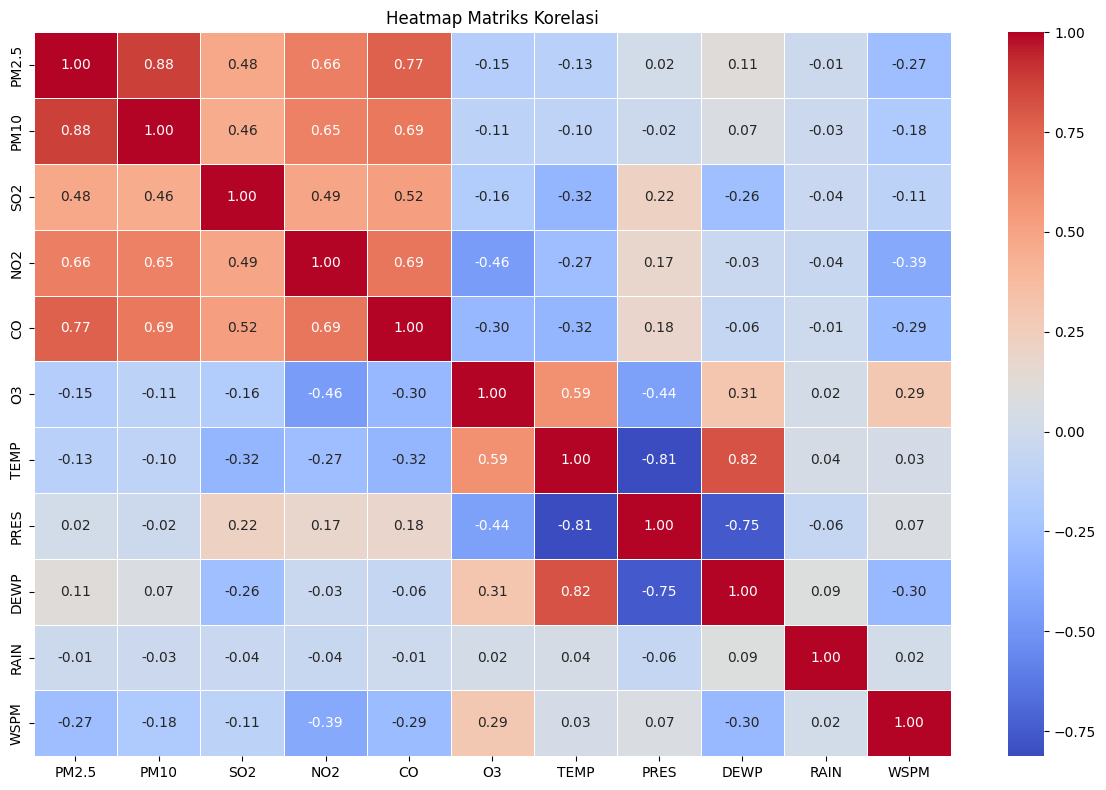

In [42]:

# Menggambar heatmap dari matriks korelasi
plt.figure(figsize=(12, 8))  # Mengatur ukuran gambar
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={'size': 10})

# Menambahkan judul
plt.title('Heatmap Matriks Korelasi')

# Menampilkan plot
plt.tight_layout()
plt.show()

**Insight:**
- Terdapat beberapa kolom yang memiliki korelasi tinggi (di atas 0.5 atau di bawah -0.5)

**A. Partikel Debu dan Gas di Udara**

1. Kolom PM2.5 memiliki korelasi positif ( >=0.5) : PM10, NO2 dan CO yang artinya semakin besar nilai PM2.5 maka nilai PM10, NO2 dan CO juga cenderung semakin besar (naik)
2. Kolom PM10 memiliki korelasi positif ( >=0.5) : PM2.5, NO2 dan CO yang artinya semakin besar nilai PM210 maka nilai PM2.5, NO2 dan CO juga cenderung semakin besar (naik)
3. Kolom SO2 memiliki korelasi positif ( >=0.5) : CO yang artinya semakin besar nilai SO2 maka nilai CO juga cenderung semakin besar (naik)
4. Kolom NO2 memiliki korelasi positif ( >=0.5) : PM2.5, PM10 dan CO yang artinya semakin besar nilai NO2 maka nilai PM2.5, PM10 dan CO juga cenderung semakin besar (naik)
5. Kolom CO memiliki korelasi positif ( >=0.5) : PM2.5, PM10, SO2 dan NO2 yang artinya semakin besar nilai CO maka nilai M2.5, PM10, SO2 dan NO2 juga cenderung semakin besar (naik)
6. Kolom O3 memiliki korelasi positif ( >=0.5) : TEMP yang artinya semakin besar nilai O3 maka nilai TEMP juga cenderung semakin besar (naik)
    
**B. Kondisi Cuaca**

1. Kolom TEMP memiliki 
    - Korelasi positif ( >=0.5) : O3 dan DEWP yang artinya semakin besar nilai TEMP maka nilai O3 dan DEWP juga cenderung semakin besar (naik).
    - Korelasi negatif ( <= - 0.5) : PRES yang artinya semakin besar nilai TEMP maka nilai PRES cenderung semakin kecil (turun).
2. Kolom PRES memiliki korelasi negatif ( <= - 0.5) : TEMP dan DEWP yang artinya semakin besar nilai PRES maka nilai TEMP dan DEWP cenderung semakin kecil (turun).  
3. Kolom DEWP memiliki 
    - Korelasi positif ( >=0.5) : O3 dan TEMP yang artinya semakin besar nilai DEWP maka nilai O3 dan TEMP juga cenderung semakin besar (naik).
    - Korelasi negatif ( <= - 0.5) : PRES yang artinya semakin besar nilai DEWP maka nilai PRES cenderung semakin kecil (turun).  

- Kolom RAIN dan WSPM tidak memiliki korelasi dengan kolom apapun
- Ada hal menarik yaitu korelasi antara O3 dengan TEMP. Dari data telah ditemukan semua partikel gas maupun debu memiliki korelasi positif, kecuali dengan O3. Gas O3 justru berkorelasi dengan kondisi udara yaitu suhu (TEMP)

### 2. Statistik Partikel Debu pada Setiap Stasiun

In [46]:
# menghitung statistik dasar partikel PM2.5 dan PM10 per stasiun
prsa_debu_allyear_df = prsa_df.groupby(["station"]).agg({
    "PM2.5": ["max", "min", "mean","std" ],
    "PM10": ["max", "min", "mean","std" ]
}).sort_values(by=[("PM2.5", "mean"), ("PM10", "mean")], ascending=False)

prsa_debu_allyear_df




PM2.5                              PM10                   \
                 max  min       mean        std    max  min        mean   
station                                                                   
Dongsi         737.0  3.0  85.655404  85.721734  955.0  2.0  109.952923   
Wanshouxigong  999.0  3.0  84.527421  85.189931  961.0  2.0  111.930504   
Nongzhanguan   844.0  2.0  84.375713  85.518369  995.0  2.0  108.690044   
Gucheng        770.0  2.0  83.412651  82.092868  994.0  2.0  118.646161   
Wanliu         957.0  2.0  83.109169  81.497468  951.0  2.0  110.282666   
Guanyuan       680.0  2.0  82.512914  80.281010  999.0  2.0  108.778322   
Aotizhongxin   898.0  3.0  82.120075  81.142233  984.0  2.0  109.588187   
Tiantan        821.0  3.0  81.717653  80.199730  988.0  2.0  105.999934   
Shunyi         941.0  2.0  78.853887  80.261997  999.0  2.0   98.397308   
Changping      882.0  2.0  70.545694  71.619188  999.0  2.0   94.281790   
Huairou        762.0  2.0  69.011408  70.346593  993.0  2.0   90.984486   
Dingling       881.0  3.0  65.434317  71.555278  905.0  2.0   83.295585   

                          
                     std  
station                   
Dongsi         97.489403  
Wanshouxigong  96.948924  
Nongzhanguan   94.778710  
Gucheng        96.237612  
Wanliu         92.440427  
Guanyuan       91.038393  
Aotizhongxin   94.299574  
Tiantan        88.976174  
Shunyi         88.485447  
Changping      82.796950  
Huairou        82.428022  
Dingling       78.859721

**Insight**

- Partikel padat yang diobservasi adalah PM2.5 dan PM10
- Dari 12 stasiun yang diobservasi sejak 2013 sampai 2017, rata-rata polutan PM2.5 dan PM10 paling tinggi adalah di stasiun Dongsi yaitu sebesar 85.66 dan 109.96, sedangkan rata-rata terendah adalah di stasiun Dingling dengan nilai 65.43 dan 83.3
- Meski memiliki rata-rata tertinggi, namun polutan PM2.5 paling buruh pernah terjadi di stasiun Wanshouxigong yaitu 999, sedangkan PM10 tertinggi pernah terjadi di stasiun Guanyuan, Shunyi dan Changping yang justru secara rata-rata PM10 stasiun Shunyi dan Changping cukup rendah relatif terhadap stasiun lainnya.
- Semua statiun pernah berada pada kondisi minim polutan padat yaitu pada nilai PM2.5 dan PM10 hanya 2.
- Data menunjukkan adanya standar deviasi yang cukup tinggi baik pada data PM2.5 maupun PM10. Pada PM2.5 standar deviasi memiliki nilai yang hampir sama dengan rata-rata dan bahkan di beberapa stasiun nilanya melebihi rata-rata. Demikian juga dengan PM10 yang standar deviasinya hampir sebesar rata-rata. Hal ini menunjukkan bahwa sebaran data cukup lebar, data memiliki ketidakpastian dan sudah tentu cenderung skewed. Data seperti ini biasanya sulit diprediksi.


In [49]:
# menghitung statistik dasar partikel PM2.5 dan PM10 per tahun
prsa_debu_yearly_df = prsa_df.groupby([ "year"]).agg({
    "PM2.5": ["max", "min", "mean","std" ],
    "PM10": ["max", "min", "mean","std" ]
})

prsa_debu_yearly_df




PM2.5                               PM10                             
        max  min       mean         std    max  min        mean         std
year                                                                       
2013  844.0  2.0  79.667875   72.362886  999.0  2.0  102.587180   80.654234
2014  809.0  3.0  84.735855   80.750741  999.0  3.0  115.344063   94.020166
2015  762.0  3.0  79.130887   83.532242  999.0  3.0  103.321585   94.611669
2016  999.0  3.0  71.565280   74.937895  995.0  3.0   94.394780   85.313069
2017  835.0  2.0  92.123176  111.879617  994.0  3.0  110.765596  123.450776

**Insight**

- Partikel padat yang diobservasi adalah PM2.5 dan PM10
- Jika dilihat dari grafik maka dapat disimpulkan bahwa tahun dengan rata-rata polusi tertinggi adalah 2017 dengan PM2.5 sebesar 92.12 dan PM10 sebesar 110.77, dan terendah adalah 2016 dengan PM2.5 sebesar 71.57 dan PM10 sebesar 94.39.
- Standar deviasi cukup tinggi dengan nilai sekitar rata-rata (bahkan lebih) yang menunjukkan distribusi data yang lebar dan penuh ketidakpastian.

### 3. Statistik Gas di Udara pada Setiap Stasiun

In [53]:
# menampilkan statistik data gas per stasiun, yang diurutkan berdasarkan rerata CO
# CO dipilih karena memiliki korelasi ke semua partikel kecuali dengan O3
prsa_gas_allyear_df = prsa_df.groupby(by="station").agg({
    "CO": ["max", "min", "mean","std"],
    "SO2": ["max", "min", "mean","std"],
    "NO2": ["max", "min", "mean","std"],
    "O3": ["max", "min", "mean","std"]
}).sort_values(by=[("CO", "mean")], ascending=False)

prsa_gas_allyear_df



CO                                     SO2          \
                   max    min         mean          std    max     min   
station                                                                  
Wanshouxigong   9800.0  100.0  1356.694302  1202.337708  411.0  0.2856   
Nongzhanguan   10000.0  100.0  1309.754991  1226.006366  257.0  0.5712   
Gucheng        10000.0  100.0  1307.034309  1187.465580  500.0  0.2856   
Dongsi         10000.0  100.0  1299.974703  1139.664773  300.0  0.2856   
Wanliu         10000.0  100.0  1297.682609  1238.397180  282.0  0.2856   
Tiantan        10000.0  100.0  1285.512720  1153.782826  273.0  0.5712   
Guanyuan       10000.0  100.0  1252.731776  1138.242638  293.0  1.0000   
Aotizhongxin   10000.0  100.0  1244.561887  1192.758674  341.0  0.2856   
Shunyi         10000.0  100.0  1163.021504  1123.773397  239.0  0.2856   
Changping      10000.0  100.0  1137.019279  1081.250627  310.0  0.2856   
Huairou        10000.0  100.0  1013.528976   881.419159  315.0  0.2856   
Dingling       10000.0  100.0   887.400896   879.868464  156.0  0.2856   

                                       NO2                                \
                    mean        std    max     min       mean        std   
station                                                                    
Wanshouxigong  16.974053  23.744348  251.0  2.0000  55.389152  35.433608   
Nongzhanguan   18.565999  24.150168  273.0  2.0000  57.957107  35.951326   
Gucheng        15.245193  21.074340  276.0  2.0000  55.759226  36.133665   
Dongsi         18.369798  22.717797  258.0  2.0000  53.393550  33.204335   
Wanliu         18.239118  22.448715  264.0  1.6424  65.098314  37.422775   
Tiantan        14.132702  19.863093  241.0  2.0000  53.031884  31.617950   
Guanyuan       17.461290  23.466455  270.0  2.0000  57.771932  34.831577   
Aotizhongxin   17.152554  22.557057  290.0  2.0000  59.121859  36.586135   
Shunyi         13.255208  19.274920  258.0  2.0000  43.639911  30.416857   
Changping      14.816361  20.813426  226.0  1.8477  44.026443  29.259029   
Huairou        11.894565  18.678989  231.0  1.0265  32.146806  25.911379   
Dingling       11.609128  15.387066  205.0  1.0265  27.283320  25.963693   

                      O3                                
                     max     min       mean        std  
station                                                 
Wanshouxigong   358.0000  0.2142  55.792422  56.252026  
Nongzhanguan    390.0000  0.2142  58.339367  58.000981  
Gucheng         450.0000  0.2142  57.430945  56.452790  
Dongsi         1071.0000  0.6426  56.962841  57.508815  
Wanliu          364.0000  0.2142  47.859676  53.580480  
Tiantan         674.0000  0.4284  55.600006  58.418310  
Guanyuan        415.0000  0.2142  55.300104  56.530697  
Aotizhongxin    423.0000  0.2142  55.649690  56.563751  
Shunyi          351.7164  0.2142  54.683189  53.752281  
Changping       429.0000  0.2142  57.734328  53.869215  
Huairou         444.0000  0.2142  59.469384  53.736632  
Dingling        500.0000  0.2142  68.287028  52.843495

In [55]:
# menampilkan statistik data gas per stasiun, yang diurutkan berdasarkan rerata SO2
prsa_SO2_allyear_df = prsa_df.groupby(by="station").agg({
    "SO2": ["max", "min", "mean","std"],

}).sort_values(by=[("SO2", "mean")], ascending=False)

prsa_SO2_allyear_df



SO2                              
                 max     min       mean        std
station                                           
Nongzhanguan   257.0  0.5712  18.565999  24.150168
Dongsi         300.0  0.2856  18.369798  22.717797
Wanliu         282.0  0.2856  18.239118  22.448715
Guanyuan       293.0  1.0000  17.461290  23.466455
Aotizhongxin   341.0  0.2856  17.152554  22.557057
Wanshouxigong  411.0  0.2856  16.974053  23.744348
Gucheng        500.0  0.2856  15.245193  21.074340
Changping      310.0  0.2856  14.816361  20.813426
Tiantan        273.0  0.5712  14.132702  19.863093
Shunyi         239.0  0.2856  13.255208  19.274920
Huairou        315.0  0.2856  11.894565  18.678989
Dingling       156.0  0.2856  11.609128  15.387066

In [57]:
# menampilkan statistik data gas per stasiun, yang diurutkan berdasarkan rerata NO2
prsa_NO2_allyear_df = prsa_df.groupby(by="station").agg({
    "NO2": ["max", "min", "mean","std"],

}).sort_values(by=[("NO2", "mean")], ascending=False)

prsa_NO2_allyear_df



NO2                              
                 max     min       mean        std
station                                           
Wanliu         264.0  1.6424  65.098314  37.422775
Aotizhongxin   290.0  2.0000  59.121859  36.586135
Nongzhanguan   273.0  2.0000  57.957107  35.951326
Guanyuan       270.0  2.0000  57.771932  34.831577
Gucheng        276.0  2.0000  55.759226  36.133665
Wanshouxigong  251.0  2.0000  55.389152  35.433608
Dongsi         258.0  2.0000  53.393550  33.204335
Tiantan        241.0  2.0000  53.031884  31.617950
Changping      226.0  1.8477  44.026443  29.259029
Shunyi         258.0  2.0000  43.639911  30.416857
Huairou        231.0  1.0265  32.146806  25.911379
Dingling       205.0  1.0265  27.283320  25.963693

In [59]:
# menampilkan statistik data gas per stasiun, yang diurutkan berdasarkan rerata O3
prsa_O3_allyear_df = prsa_df.groupby(by="station").agg({
    "O3": ["max", "min", "mean","std"],

}).sort_values(by=[("O3", "mean")], ascending=False)

prsa_O3_allyear_df



O3                              
                     max     min       mean        std
station                                               
Dingling        500.0000  0.2142  68.287028  52.843495
Huairou         444.0000  0.2142  59.469384  53.736632
Nongzhanguan    390.0000  0.2142  58.339367  58.000981
Changping       429.0000  0.2142  57.734328  53.869215
Gucheng         450.0000  0.2142  57.430945  56.452790
Dongsi         1071.0000  0.6426  56.962841  57.508815
Wanshouxigong   358.0000  0.2142  55.792422  56.252026
Aotizhongxin    423.0000  0.2142  55.649690  56.563751
Tiantan         674.0000  0.4284  55.600006  58.418310
Guanyuan        415.0000  0.2142  55.300104  56.530697
Shunyi          351.7164  0.2142  54.683189  53.752281
Wanliu          364.0000  0.2142  47.859676  53.580480

**Insight**

- Partikel gas yang diobservasi adalah CO, SO2, NO2 dan O3
- Rata-rata gas CO:
    - Rata-rata partikel polutan CO paling banyak ditemukan di stasiun Wanshouxigong sebesar 1356 dan paling rendah di statsiun Dingling sebesar 887.
    - Dua stasiun lain dengan nilai CO tertinggi adalah Nongzhanguan dan Gucheng
    - Nilai gas CO terkecil yaitu dengan konsentrasi 100, pernah terjadi di semua stasiun
    - Ada hal menarik mengenai konsentrasi maksimum gas CO yaitu 10.000 yang pernah terjadi di semua stasiun termasuk Dingling, namun stasiun Wanshouxigong dengan rerata polutan tertinggi justru hanya mencapau maksimal CO sebesar 9800
    - Standar deviasi cukup tinggi karena mendekati nilai rata-rata, yang menunjukkan distribusi data yang lebar dan adanya ketidakpastian.
    
- Rata-rata gas SO2:
    - Rata-rata partikel polutan SO2 paling banyak ditemukan di stasiun Nongzhanguan sebesar 18.56 dan paling rendah di statsiun Dingling sebesar 11.61.
    - Dua stasiun lain dengan nilai SO2 tertinggi adalah Dongsi dan Wanliu
    - Nilai S02 tertinggi pernah terjadi di Gucheng yaitu sebesar 500, dan paling rendah 0.286 yang pernah terjadi di hampir semua stasiun termasuk Gucheng.
    - Standar deviasi cukup tinggi bahkan melebihi nilai rata-rata, yang menunjukkan distribusi data yang lebar dan adanya ketidakpastian.
    
- Rata-rata gas NO2:
    - Rata-rata partikel polutan NO2 paling banyak ditemukan di stasiun Wanliu sebesar 65.09 dan paling rendah di statsiun Dingling sebesar 27.28.
    - Dua stasiun lain dengan nilai CO tertinggi adalah Aotizhongxin dan Nongzhanguan
    - Konsentrasi NO2 tertinggi pernah terjadi di Aotizhongxin dengan nilai mencapai 290 dan terendah mencapai 1.03 di Huairou dan Dingling.
    - Standar deviasi agak tinggi yaitu sekitar setengah dari nilai rata-rata. Ini menunjukkan sebaran data NO2 tidak selebar CO maupun SO2, namun masih cukup lebar dan bersifat skewed, namun masih lebih merata dibandingkan dengan SO2 maupun CO
    
- Rata-rata gas O3:
    - Rata-rata partikel O3 paling banyak ditemukan di stasiun Dingling sebesar 68.29 dan paling rendah di statsiun Wanliu sebesar 47.86.
    - Dua stasiun dengan O3 terendah lainnya adalah: Guanyuan dan Shunyi
    - Nilai O3 tertinggi pernah terjadi di Dongsi dengan nilai 1071, dan paling rendah 0.2142 yang pernah terjadi di hampir semua stasiun termasuk Gucheng.
    - Standar deviasi cukup tinggi bahkan melebihi nilai rata-rata, yang menunjukkan distribusi data yang lebar dan adanya ketidakpastian.
    
**Kesimpulan**

- Stasiun dengan nilai polutan rata-rata tertinggi adalah Nongzhanguan karena menduduki posisi tiga besar stasiun dengan gas CO, SO2 dan NO2 tertinggi
- Sedangkan stasiun dengan polutan terendah yaitu Dingling dengan nilai gas CO, SO2 dan NO2 terendah, sedangkan O3 paling tinggi yang menunjukkan gas ozon paling baik.

## Visualization & Explanatory Analysis

### Pertanyaan 1

Bagaimana korelasi antar setiap kolom dalam dataset?

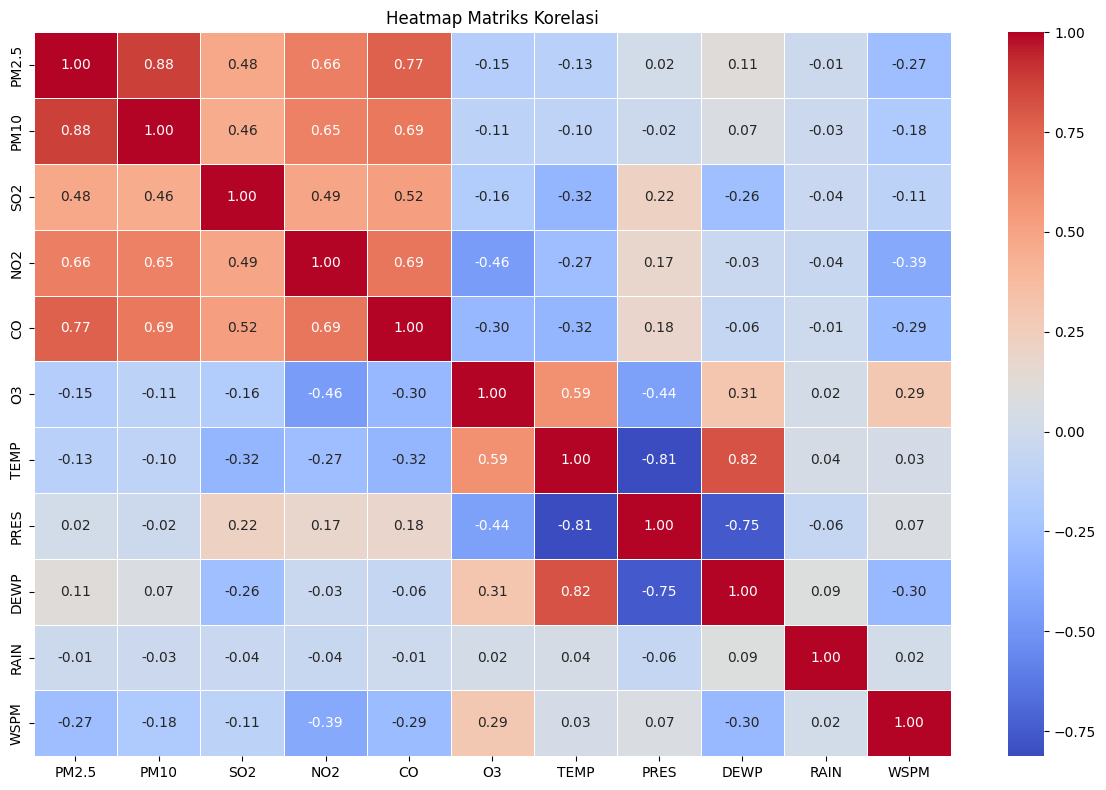

In [64]:

# Menggambar heatmap dari matriks korelasi
plt.figure(figsize=(12, 8))  # Mengatur ukuran gambar
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={'size': 10})

# Menambahkan judul
plt.title('Heatmap Matriks Korelasi')

# Menampilkan plot
plt.tight_layout()
plt.show()

**Insight:**
- Terdapat beberapa kolom yang memiliki korelasi tinggi (di atas 0.5 atau di bawah -0.5)

**A. Partikel Debu dan Gas di Udara**

1. Kolom PM2.5 memiliki korelasi positif ( >=0.5) : PM10, NO2 dan CO yang artinya semakin besar nilai PM2.5 maka nilai PM10, NO2 dan CO juga cenderung semakin besar (naik)
2. Kolom PM10 memiliki korelasi positif ( >=0.5) : PM2.5, NO2 dan CO yang artinya semakin besar nilai PM210 maka nilai PM2.5, NO2 dan CO juga cenderung semakin besar (naik)
3. Kolom SO2 memiliki korelasi positif ( >=0.5) : CO yang artinya semakin besar nilai SO2 maka nilai CO juga cenderung semakin besar (naik)
4. Kolom NO2 memiliki korelasi positif ( >=0.5) : PM2.5, PM10 dan CO yang artinya semakin besar nilai NO2 maka nilai PM2.5, PM10 dan CO juga cenderung semakin besar (naik)
5. Kolom CO memiliki korelasi positif ( >=0.5) : PM2.5, PM10, SO2 dan NO2 yang artinya semakin besar nilai CO maka nilai M2.5, PM10, SO2 dan NO2 juga cenderung semakin besar (naik)
6. Kolom O3 memiliki korelasi positif ( >=0.5) : TEMP yang artinya semakin besar nilai O3 maka nilai TEMP juga cenderung semakin besar (naik)
    
**B. Kondisi Cuaca**

1. Kolom TEMP memiliki 
    - Korelasi positif ( >=0.5) : O3 dan DEWP yang artinya semakin besar nilai TEMP maka nilai O3 dan DEWP juga cenderung semakin besar (naik).
    - Korelasi negatif ( <= - 0.5) : PRES yang artinya semakin besar nilai TEMP maka nilai PRES cenderung semakin kecil (turun).
2. Kolom PRES memiliki korelasi negatif ( <= - 0.5) : TEMP dan DEWP yang artinya semakin besar nilai PRES maka nilai TEMP dan DEWP cenderung semakin kecil (turun).  
3. Kolom DEWP memiliki 
    - Korelasi positif ( >=0.5) : O3 dan TEMP yang artinya semakin besar nilai DEWP maka nilai O3 dan TEMP juga cenderung semakin besar (naik).
    - Korelasi negatif ( <= - 0.5) : PRES yang artinya semakin besar nilai DEWP maka nilai PRES cenderung semakin kecil (turun).  

- Kolom RAIN dan WSPM tidak memiliki korelasi dengan kolom apapun
- Ada hal menarik yaitu korelasi antara O3 dengan TEMP. Dari data telah ditemukan semua partikel gas maupun debu memiliki korelasi positif, kecuali dengan O3. Gas O3 justru berkorelasi dengan kondisi udara yaitu suhu (TEMP)

### Pertanyaan 2

Bagaimana rata-rata polutan dalam bentuk partikel debu pada setiap stasiun?

In [68]:
prsa_debu_allyear_df

PM2.5                              PM10                   \
                 max  min       mean        std    max  min        mean   
station                                                                   
Dongsi         737.0  3.0  85.655404  85.721734  955.0  2.0  109.952923   
Wanshouxigong  999.0  3.0  84.527421  85.189931  961.0  2.0  111.930504   
Nongzhanguan   844.0  2.0  84.375713  85.518369  995.0  2.0  108.690044   
Gucheng        770.0  2.0  83.412651  82.092868  994.0  2.0  118.646161   
Wanliu         957.0  2.0  83.109169  81.497468  951.0  2.0  110.282666   
Guanyuan       680.0  2.0  82.512914  80.281010  999.0  2.0  108.778322   
Aotizhongxin   898.0  3.0  82.120075  81.142233  984.0  2.0  109.588187   
Tiantan        821.0  3.0  81.717653  80.199730  988.0  2.0  105.999934   
Shunyi         941.0  2.0  78.853887  80.261997  999.0  2.0   98.397308   
Changping      882.0  2.0  70.545694  71.619188  999.0  2.0   94.281790   
Huairou        762.0  2.0  69.011408  70.346593  993.0  2.0   90.984486   
Dingling       881.0  3.0  65.434317  71.555278  905.0  2.0   83.295585   

                          
                     std  
station                   
Dongsi         97.489403  
Wanshouxigong  96.948924  
Nongzhanguan   94.778710  
Gucheng        96.237612  
Wanliu         92.440427  
Guanyuan       91.038393  
Aotizhongxin   94.299574  
Tiantan        88.976174  
Shunyi         88.485447  
Changping      82.796950  
Huairou        82.428022  
Dingling       78.859721

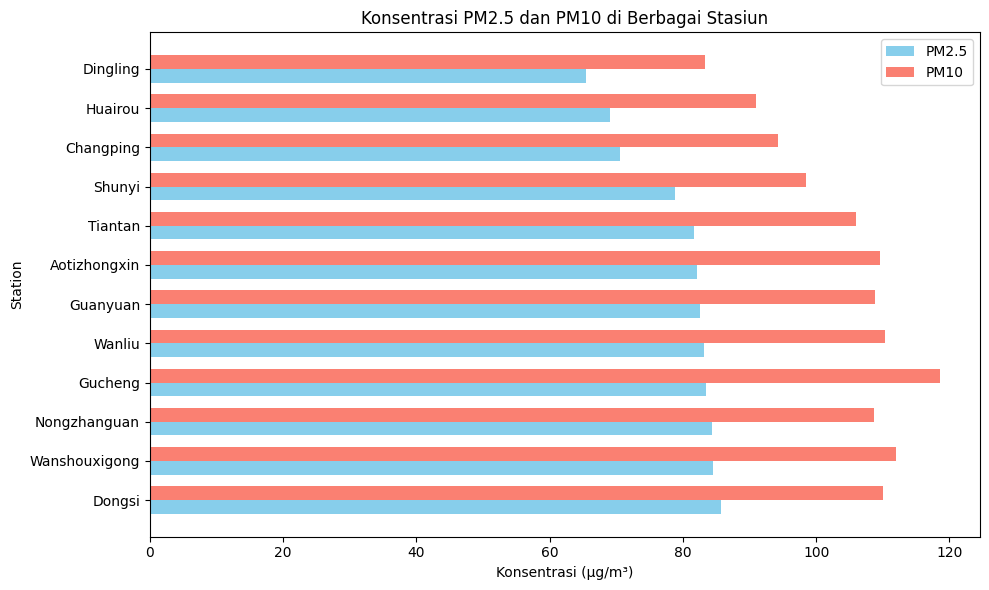

In [70]:
# menggambarkan rata-rata PM3.5 dan PM10 per stasiun

# Reset indeks dan memperbaiki nama kolom
prsa_debu_allyear_df_reset = prsa_debu_allyear_df.reset_index()
prsa_debu_allyear_df_reset.columns = ['station', 'PM2.5_max', 'PM2.5_min', 'PM2.5_mean', 'PM2.5_std',
                                      'PM10_max', 'PM10_min', 'PM10_mean', 'PM10_std']

# Membuat bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(prsa_debu_allyear_df_reset['station']))

# Plot PM2.5 dan PM10
bar1 = ax.barh(index, prsa_debu_allyear_df_reset['PM2.5_mean'], bar_width, label='PM2.5', color='skyblue')
bar2 = ax.barh([i + bar_width for i in index], prsa_debu_allyear_df_reset['PM10_mean'], bar_width, label='PM10', color='salmon')

# Menambahkan label
ax.set_ylabel('Station')
ax.set_xlabel('Konsentrasi (µg/m³)')
ax.set_title('Konsentrasi PM2.5 dan PM10 di Berbagai Stasiun')
ax.set_yticks([i + bar_width / 2 for i in index])
ax.set_yticklabels(prsa_debu_allyear_df_reset['station'])
ax.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()



**Insight**

- Konsentrasi rata-rata polutan padat dalam bentuk partikel debu PM2.5 terbanyak ada di Dongsi, sedangkan paling sedikit di stasiun Dingling
- Besarnya konsentrasi PM2.5 sebenarnya tidak jauh berbeda antara Dongsi, Wanshouxigong dan Nongzhanguan.
- Konsentrasi rata-rata polutan padat dalam bentuk partikel debu PM10 terpantau lebih tinggi daripada PM2.5 di semua stasiun
- Rata-rata PM10 tertinggi terjadi di stasiun Gucheng dan terendah di Dingling
- Dengan melihat rata-rata PM2.5 dan PM10 maka dapat disimpulkan bahwa Dingling adalah stasiun dengan polusi paling rendah

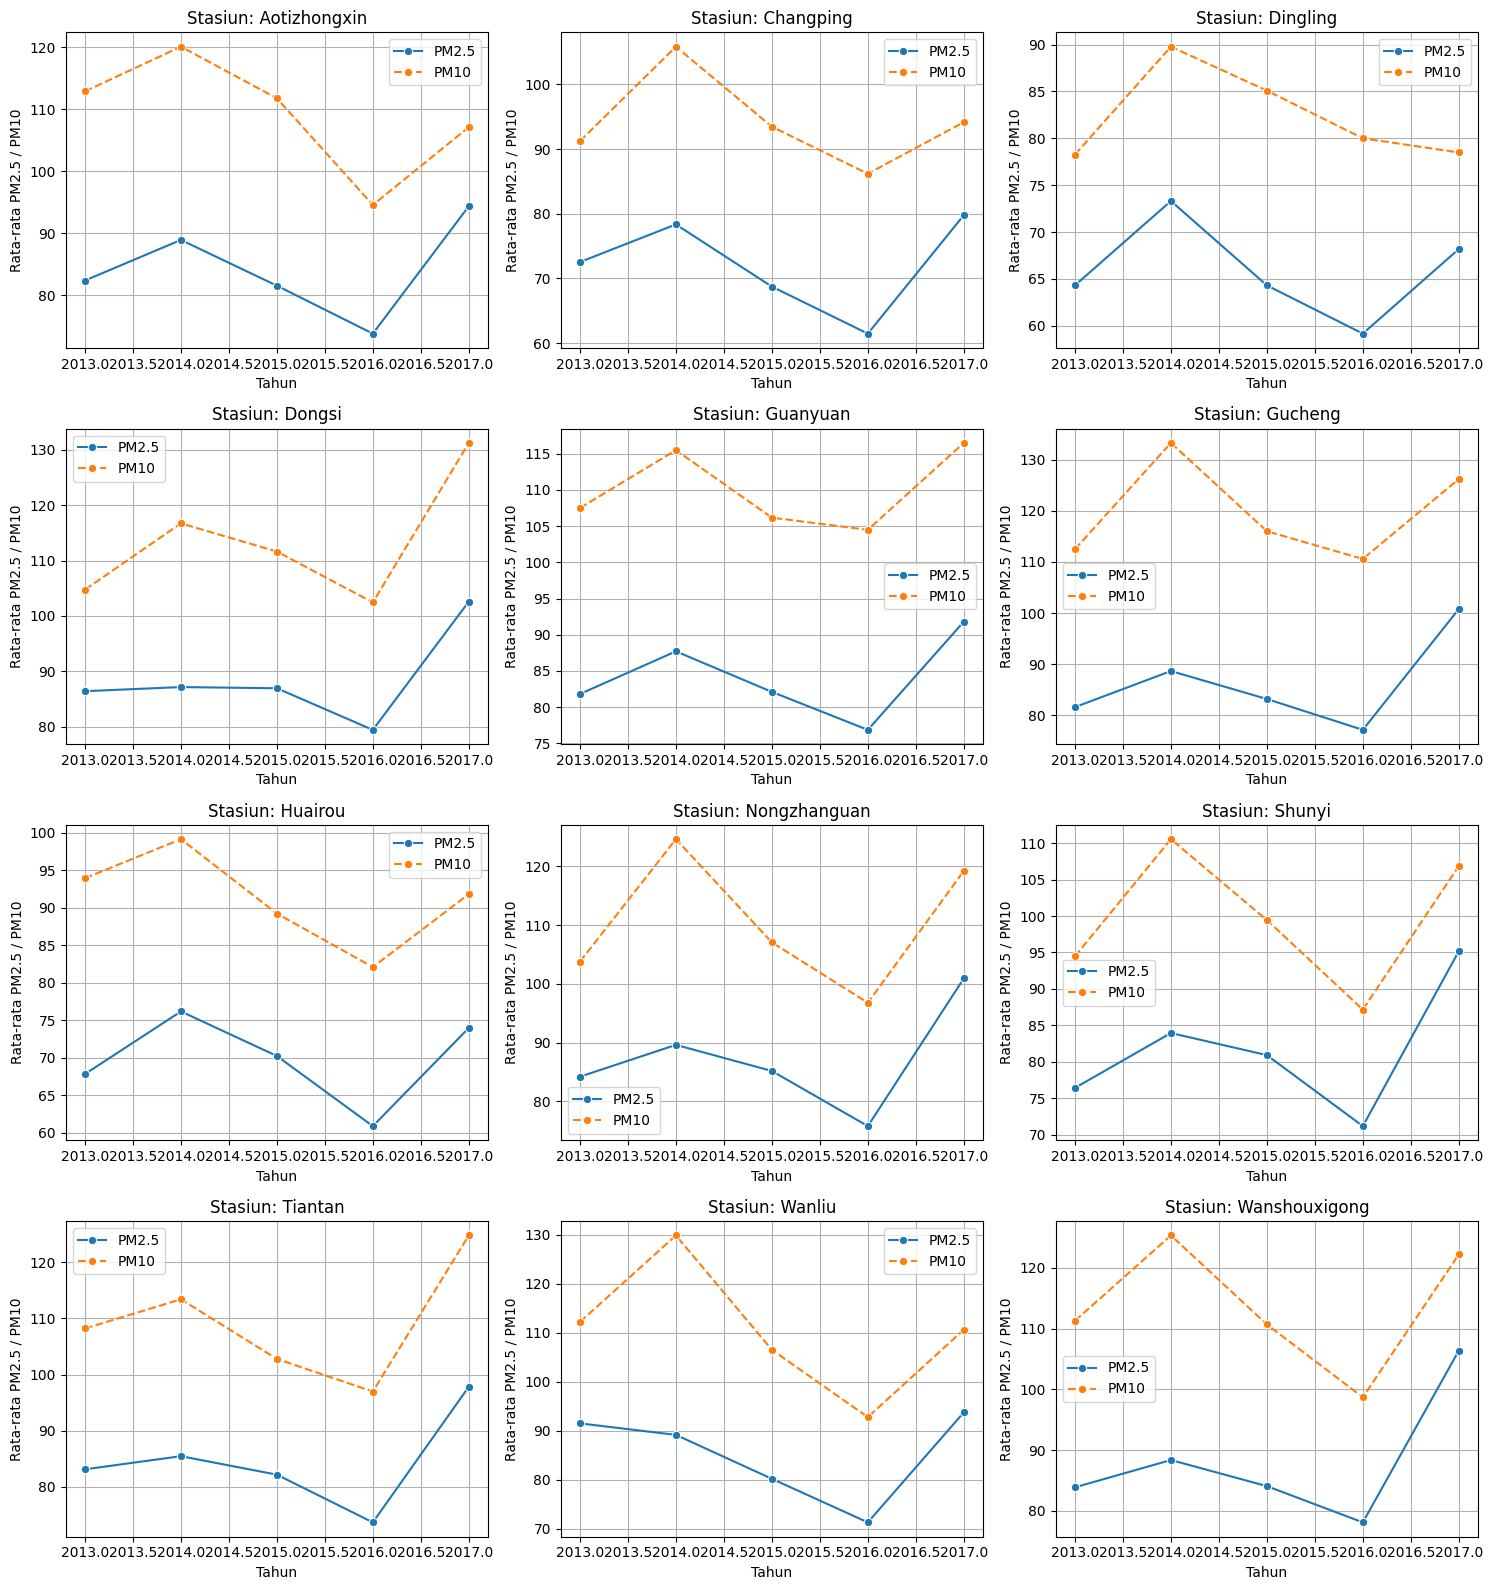

In [73]:
# menghitung statistik dasar partikel PM2.5 dan PM10 per stasiun per tahun
prsa_debu_df = prsa_df.groupby(["station", "year"]).agg({
    "PM2.5": ["mean"],
    "PM10": ["mean"]
}).reset_index()


# Mengatur ulang nama kolom
prsa_debu_df.columns = ['station', 'year', 'PM2.5_mean', 'PM10_mean']

# Menentukan jumlah baris dan kolom untuk subplot
num_stations = len(prsa_debu_df['station'].unique())  # Dapatkan jumlah stasiun unik
cols = 3  # Tentukan jumlah kolom
rows = (num_stations + cols - 1) // cols  # Tentukan jumlah baris, pembulatan ke atas

# Membuat figure dan subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()  # Flatten untuk memudahkan akses pada setiap subplot

# Plot masing-masing stasiun
for idx, station in enumerate(prsa_debu_df['station'].unique()):
    ax = axes[idx]
    
    # Filter data untuk setiap stasiun
    station_data = prsa_debu_df[prsa_debu_df['station'] == station]
    
    # Plot PM2.5 dan PM10
    sn.lineplot(data=station_data, x="year", y="PM2.5_mean", ax=ax, marker="o", label="PM2.5")
    sn.lineplot(data=station_data, x="year", y="PM10_mean", ax=ax, marker="o", linestyle="--", label="PM10")
    
    # Menambahkan judul dan label
    ax.set_title(f"Stasiun: {station}")
    ax.set_xlabel("Tahun")
    ax.set_ylabel("Rata-rata PM2.5 / PM10")
    ax.grid(True)
    ax.legend()

# Menyesuaikan layout
plt.tight_layout()
plt.show()





**Insight**

- Dari grafik trend PM2.5 dan PM10 tahunan, dapat dilihat bahwa trend keduanya berjalan searah, kecuali di stasiun Dingling dan Wanliu, dimana di tahun 2017 terjadi penurunan PM2.5 di Dingling namun PM10 naik, sementara itu di Wanliu pada tahun 2014 PM2.5 mengalami sedikit penurunan namun kenaikan PM10 yang cukup drastis.
- Secara umum di hampir semua stasiun, PM2.5 dan PM10 mengalami penurunan sejak 2014 dan paling rendah di tahun 2016, kemudian mengalami kenaikan yang jauh dibandingkan dengan tahun-tahun sebelumnya pada 2017.
- Ada pola yang berbeda di Dingling, dimana justru di tahun 2017, PM2.5 menduduki posisi terendah.

In [75]:
# menghitung statistik dasar partikel PM2.5 dan PM10 per stasiun
prsa_debu_hours_df = prsa_df.groupby(["station","hour"]).agg({
    "PM2.5": ["max", "min", "mean","std" ],
    "PM10": ["max", "min", "mean","std" ]
})
#.sort_values(by=[("PM2.5", "mean"), ("PM10", "mean")], ascending=False)
prsa_debu_hours_df




PM2.5                              PM10                   \
                      max  min       mean        std    max  min        mean   
station       hour                                                             
Aotizhongxin  0     584.0  3.0  91.573580  89.078953  844.0  4.0  123.986995   
              1     576.0  3.0  91.323066  89.232103  873.0  5.0  122.992197   
              2     898.0  3.0  90.949281  89.867338  845.0  4.0  119.664271   
              3     713.0  3.0  87.937166  85.499143  884.0  2.0  113.924230   
              4     682.0  3.0  84.718686  81.916661  815.0  3.0  108.660917   
...                   ...  ...        ...        ...    ...  ...         ...   
Wanshouxigong 19    664.0  3.0  86.801027  86.620424  680.0  3.0  125.670773   
              20    618.0  3.0  92.047228  89.407784  676.0  2.0  132.535934   
              21    589.0  3.0  95.091239  90.402824  691.0  3.0  134.131622   
              22    597.0  3.0  94.611225  91.055730  730.0  3.0  130.271732   
              23    704.0  3.0  94.183641  91.983690  836.0  3.0  126.727515   

                                
                           std  
station       hour              
Aotizhongxin  0     103.767670  
              1     106.162932  
              2     102.972848  
              3     100.404017  
              4      96.930228  
...                        ...  
Wanshouxigong 19     95.207663  
              20     98.357154  
              21     99.621006  
              22    101.907624  
              23    104.700948  

[288 rows x 8 columns]

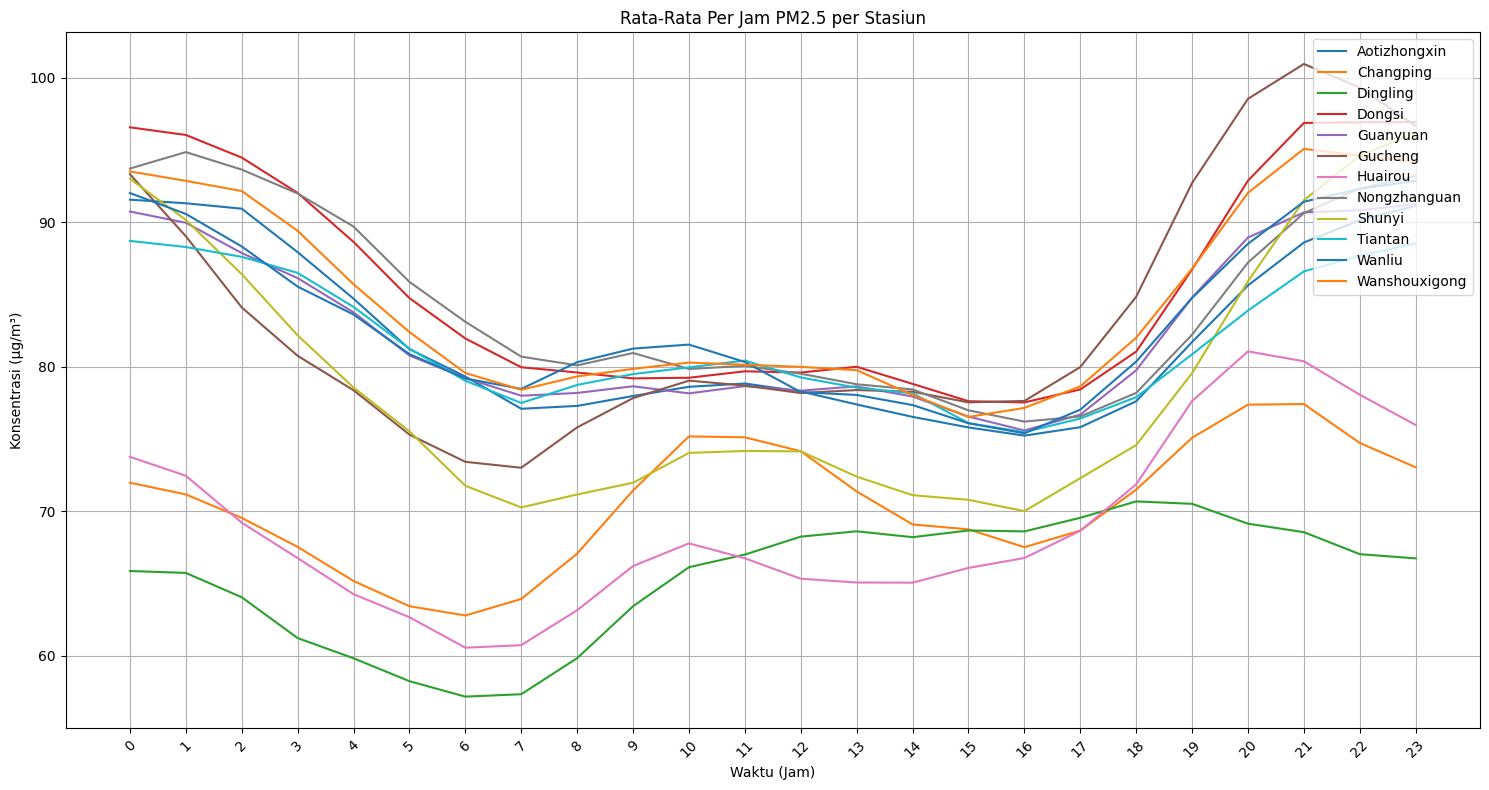

In [78]:
# Reset indeks untuk mempermudah plotting
prsa_debu_hour_df_reset = prsa_debu_hours_df.reset_index()

# Menggabungkan PM2.5 untuk mempermudah visualisasi
plt.figure(figsize=(15, 8))  # Mengatur ukuran grafik

# Plot untuk PM2.5
for station in prsa_debu_hour_df_reset["station"].unique():
    data_station = prsa_debu_hour_df_reset[prsa_debu_hour_df_reset["station"] == station]
    plt.plot(data_station[["hour"]].apply(lambda x: f'{x[0]}', axis=1), 
             data_station[("PM2.5", "mean")], label=station)


# Konfigurasi grafik
plt.xlabel("Waktu (Jam)")
plt.ylabel("Konsentrasi (µg/m³)")
plt.title("Rata-Rata Per Jam PM2.5 per Stasiun")
plt.xticks(rotation=45)  # Memutar label sumbu-x
plt.legend(loc='upper right')  # Menampilkan legenda
plt.grid(True)  # Menambahkan grid
plt.tight_layout()  # Menyesuaikan layout agar tidak tumpang tindih
plt.show()


**Insight**

- Dari grafik terlihat bahwa partikel PM2.5 secara umum memiliki nilai yang tinggi di jam 18.00 hingga pukul 05.00 pagi hari hampir di seluruh stasiun.
- PM2.5 paling rendah secara umum terjadi di jam 07.00 hingga 17.00
- Dingling menjadi perkecualian, dimana PM2.5 tertinggi berda pada pukul 09.00 hingga 01.00 dan memiliki PM2.5 terendah di jam 03.00 hingga 08.00 pagi.

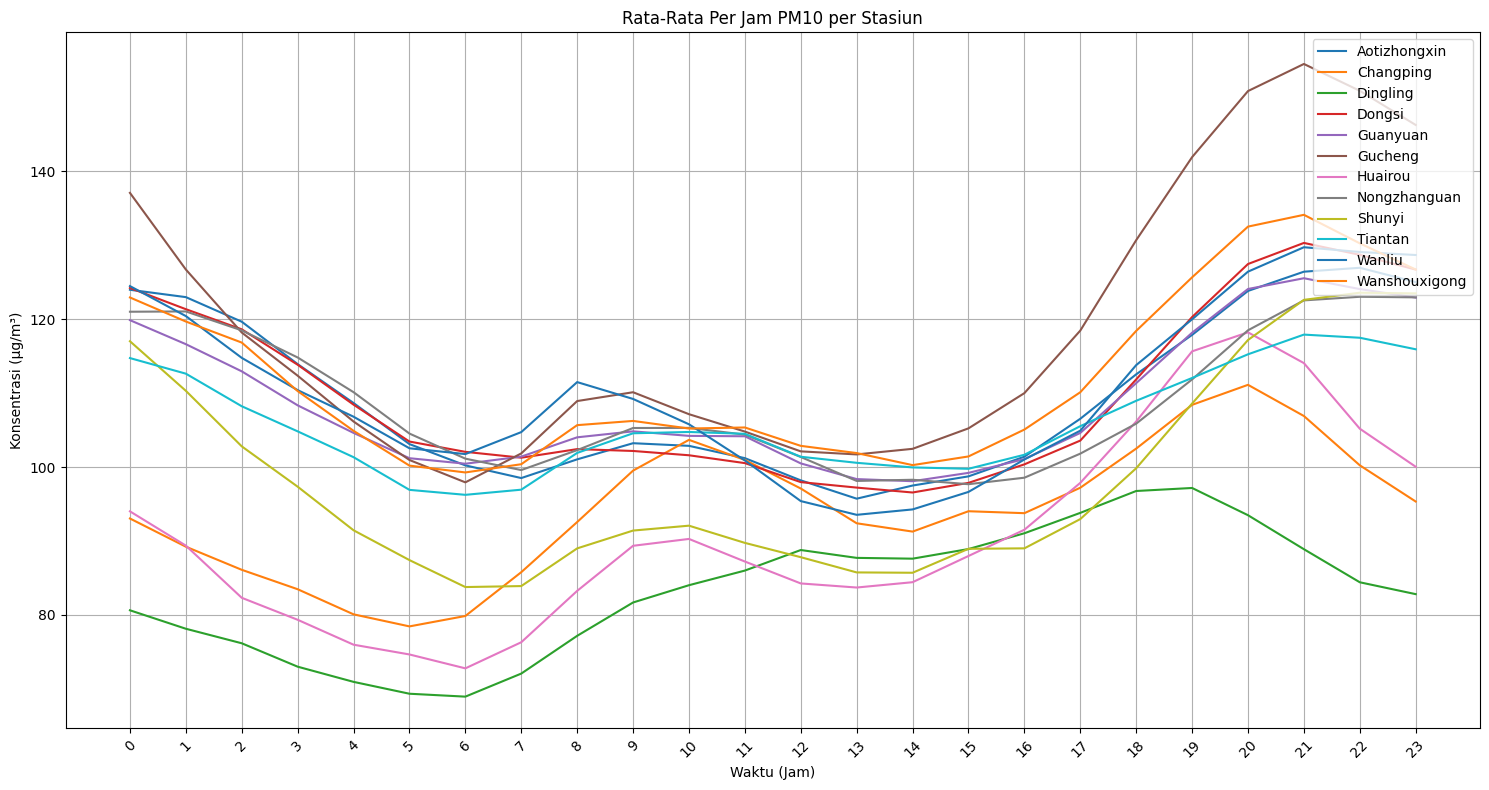

In [81]:
# Reset indeks untuk mempermudah plotting
prsa_debu_hour_df_reset = prsa_debu_hours_df.reset_index()

# Menggabungkan PM10 untuk mempermudah visualisasi
plt.figure(figsize=(15, 8))  # Mengatur ukuran grafik

# Plot untuk PM10
for station in prsa_debu_hour_df_reset["station"].unique():
    data_station = prsa_debu_hour_df_reset[prsa_debu_hour_df_reset["station"] == station]
    plt.plot(data_station[["hour"]].apply(lambda x: f'{x[0]}', axis=1), 
             data_station[("PM10", "mean")], label=station)


# Konfigurasi grafik
plt.xlabel("Waktu (Jam)")
plt.ylabel("Konsentrasi (µg/m³)")
plt.title("Rata-Rata Per Jam PM10 per Stasiun")
plt.xticks(rotation=45)  # Memutar label sumbu-x
plt.legend(loc='upper right')  # Menampilkan legenda
plt.grid(True)  # Menambahkan grid
plt.tight_layout()  # Menyesuaikan layout agar tidak tumpang tindih
plt.show()


**Insight**

- Dari grafik terlihat bahwa partikel PM10 secara umum memiliki nilai yang tinggi di jam 17.00 hingga pukul 04.00 pagi hari hampir di seluruh stasiun
- PM10 paling rendah secara umum terjadi di jam 05.00 hingga 07.00 dan di jam 12.00 hingga 15.00


In [84]:
# menghitung statistik dasar partikel PM2.5 dan PM10 per stasiun per bulan
prsa_debu_month_df = prsa_df.groupby(["station", "year", "month"]).agg({
    "PM2.5": ["max", "min", "mean" ],
    "PM10": ["max", "min", "mean" ]
})

prsa_debu_month_df




PM2.5                    PM10                  
                            max  min        mean    max   min        mean
station       year month                                                 
Aotizhongxin  2013 3      463.0  3.0  110.092742  844.0   3.0  143.923387
                   4      263.0  3.0   62.751389  358.0   6.0  108.204167
                   5      665.0  5.0   84.915323  655.0  11.0  140.778226
                   6      510.0  3.0  106.025000  564.0   3.0  128.716667
                   7      271.0  3.0   68.911290  396.0   3.0   85.375000
...                         ...  ...         ...    ...   ...         ...
Wanshouxigong 2016 10     305.0  3.0   83.256720  305.0   6.0   94.389785
                   11     399.0  3.0  106.423611  470.0   6.0  136.377778
                   12     569.0  3.0  156.810484  600.0   6.0  169.143817
              2017 1      823.0  3.0  131.932796  952.0   5.0  149.370968
                   2      413.0  3.0   78.071429  413.0   4.0   92.096726

[576 rows x 6 columns]

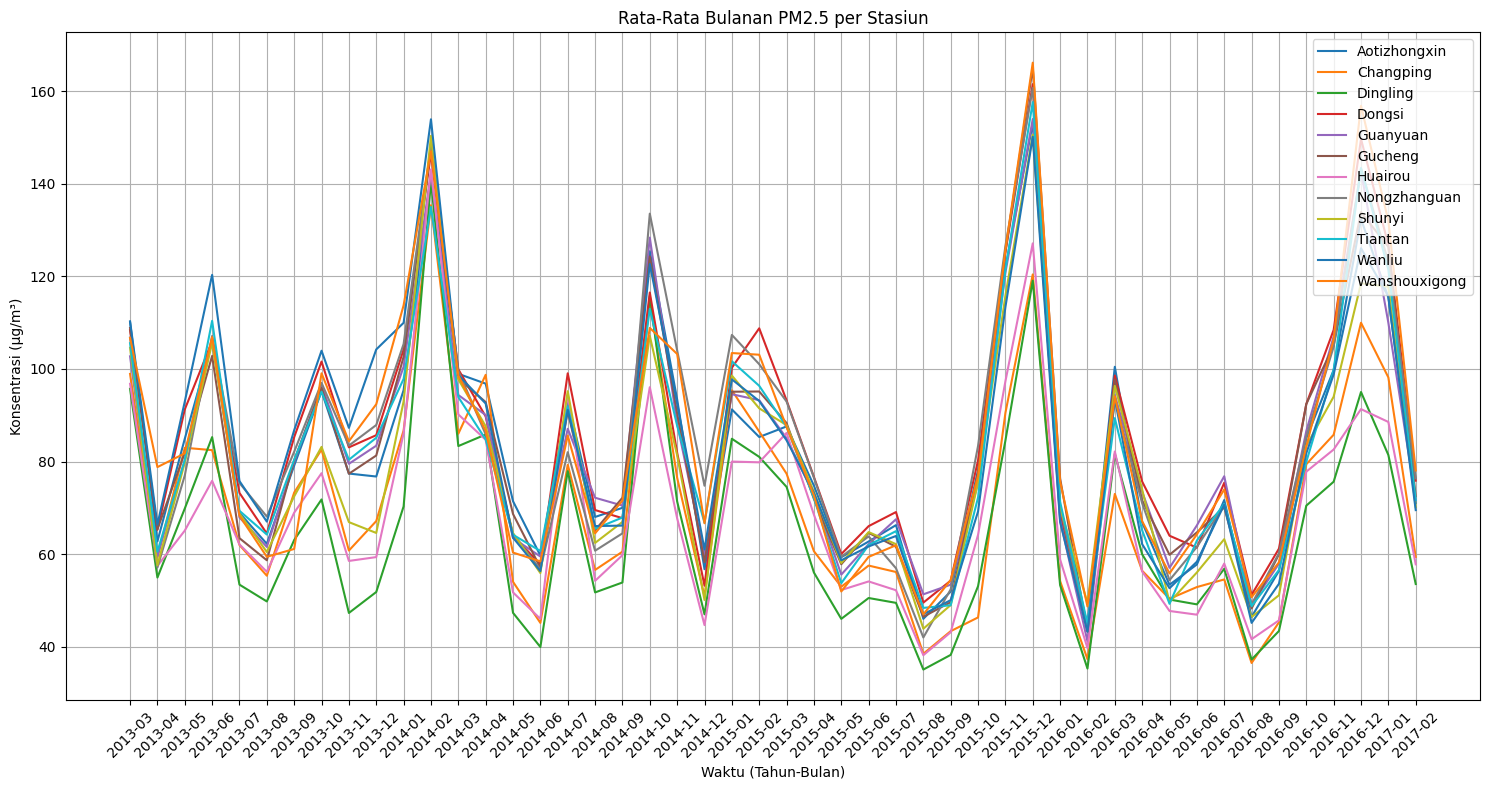

In [86]:
# Reset indeks untuk mempermudah plotting
prsa_debu_month_df_reset = prsa_debu_month_df.reset_index()

# Menggabungkan PM2.5 untuk mempermudah visualisasi
plt.figure(figsize=(15, 8))  # Mengatur ukuran grafik

# Plot untuk PM2.5
for station in prsa_debu_month_df_reset["station"].unique():
    data_station = prsa_debu_month_df_reset[prsa_debu_month_df_reset["station"] == station]
    plt.plot(data_station[["year", "month"]].apply(lambda x: f'{x[0]}-{x[1]:02}', axis=1), 
             data_station[("PM2.5", "mean")], label=station)


# Konfigurasi grafik
plt.xlabel("Waktu (Tahun-Bulan)")
plt.ylabel("Konsentrasi (µg/m³)")
plt.title("Rata-Rata Bulanan PM2.5 per Stasiun")
plt.xticks(rotation=45)  # Memutar label sumbu-x
plt.legend(loc='upper right')  # Menampilkan legenda
plt.grid(True)  # Menambahkan grid
plt.tight_layout()  # Menyesuaikan layout agar tidak tumpang tindih
plt.show()


**Insight**

- Dari grafik terlihat bahwa rata-rata PM2.5 bulanan, paling rendah di bulan Juli hampir setiap tahunnya, kecuali 2014, dimana PM2.5 terendah adalah di bulan Mei, namun di Bulan Juli masih tergolong rendah meski tidak serendah bulan Mei di tahun yang sama
- Nilai PM2.5 di dua tahun terakhir observasi terjadi di bulan Nopember, dimana PM2.5 secara drastis melonjak.

### Pertanyaan 3

Bagaimana rata-rata polutan dalam bentuk gas per stasiun pada setiap stasiun?

In [90]:
# Mengelompokkan data per stasiun dan menghitung statistik
prsa_gas_allyear_df = prsa_df.groupby(by="station").agg({
    "CO": "mean",
    "SO2": "mean",
    "NO2": "mean",
    "O3": "mean"
}).sort_values(by="CO", ascending=False).reset_index()

# Menampilkan dataframe hasil
prsa_gas_allyear_df


,station,CO,SO2,NO2,O3
0,Wanshouxigong,1356.694302,16.974053,55.389152,55.792422
1,Nongzhanguan,1309.754991,18.565999,57.957107,58.339367
2,Gucheng,1307.034309,15.245193,55.759226,57.430945
3,Dongsi,1299.974703,18.369798,53.393550,56.962841
4,Wanliu,1297.682609,18.239118,65.098314,47.859676
5,Tiantan,1285.512720,14.132702,53.031884,55.600006
6,Guanyuan,1252.731776,17.461290,57.771932,55.300104
7,Aotizhongxin,1244.561887,17.152554,59.121859,55.649690
8,Shunyi,1163.021504,13.255208,43.639911,54.683189
9,Changping,1137.019279,14.816361,44.026443,57.734328


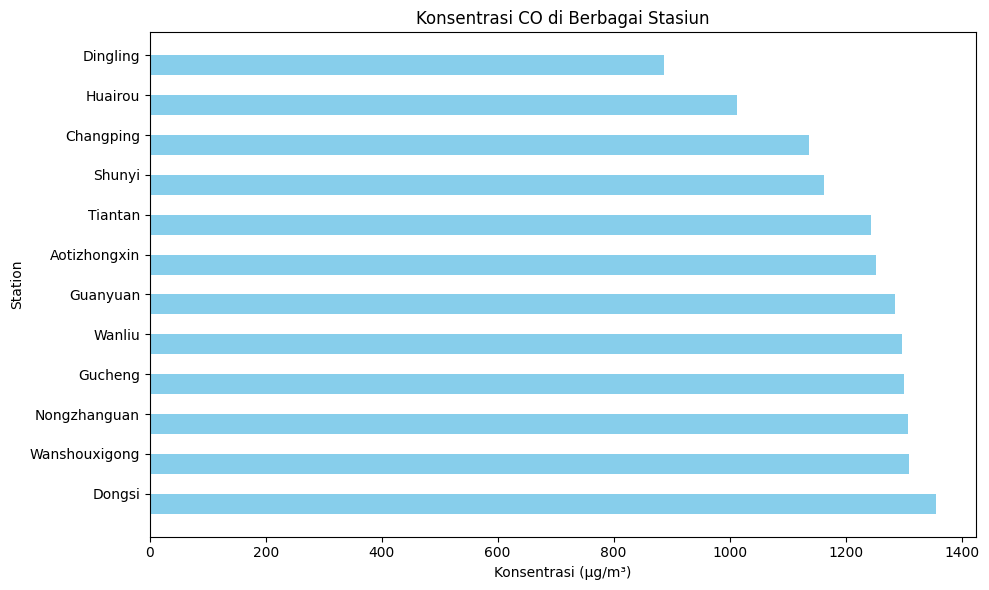

In [92]:

# Membuat bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5
index = range(len(prsa_gas_allyear_df['station']))

# Plot CO
bar1 = ax.barh(index, prsa_gas_allyear_df['CO'], bar_width, label='CO', color='skyblue')


# Menambahkan label
ax.set_ylabel('Station')
ax.set_xlabel('Konsentrasi (µg/m³)')
ax.set_title('Konsentrasi CO di Berbagai Stasiun')
ax.set_yticks([i + bar_width / 2 for i in index])
ax.set_yticklabels(prsa_debu_allyear_df_reset['station'])


# Menampilkan plot
plt.tight_layout()
plt.show()



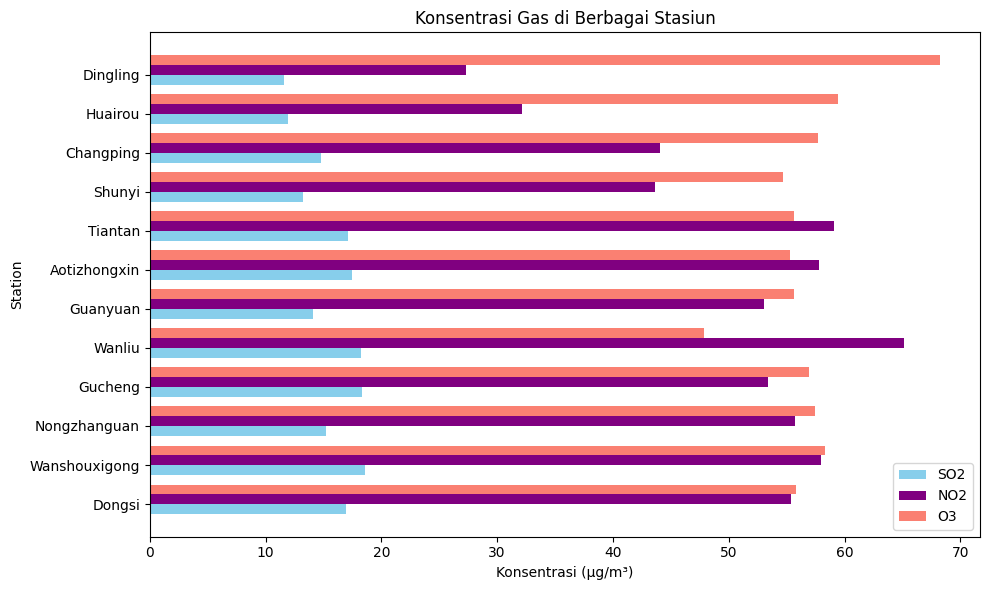

In [94]:
# Membuat bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
index = range(len(prsa_gas_allyear_df['station']))

# Plot CO
bar1 = ax.barh(index, prsa_gas_allyear_df['SO2'], bar_width, label='SO2', color='skyblue')
bar2 = ax.barh([i + bar_width for i in index], prsa_gas_allyear_df['NO2'], bar_width, label='NO2', color='purple')
bar3 = ax.barh([i + 2*bar_width for i in index], prsa_gas_allyear_df['O3'], bar_width, label='O3', color='salmon')

# Menambahkan label
ax.set_ylabel('Station')
ax.set_xlabel('Konsentrasi (µg/m³)')
ax.set_title('Konsentrasi Gas di Berbagai Stasiun')
ax.set_yticks([i + bar_width / 2 for i in index])
ax.set_yticklabels(prsa_debu_allyear_df_reset['station'])
ax.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()



**Insight**

- Penggambaran CO dilakukan tersendiri karena nilainya jauh lebih tinggi dibandingkan gas lain, sehingga akan lebih mudah melihat informasi visual jika gas lainnya dipisahkan
- Dari grafik dapat dilihat bahwa konsentrasi gas CO tertinggi ada Dongsi dan terendah di Dingling
- Gas NO2 rata-rata tertinggi di Wanliu dan terendah di Dingling
- Gas SO2 rata-rata tertinggi di Huairou dan terendah di Dingling
- Untuk rata-rata O3 tertinggi ada di Dingling dan terendah ada di Wanliu

## Analisis Lanjutan

### Pertanyaan 4

Bagaimana penggolongan polutan dalam bentuk partikel debu pada setiap stasiun?

In [99]:
# Mengelompokkan berdasarkan station dan menghitung rata-rata untuk PM2.5 dan PM10
pm25_pm10_mean_df = prsa_df.groupby('station')[['PM2.5', 'PM10']].mean().reset_index()

# Menampilkan hasil rata-rata PM2.5 dan PM10
pm25_pm10_mean_df


,station,PM2.5,PM10
0,Aotizhongxin,82.120075,109.588187
1,Changping,70.545694,94.281790
2,Dingling,65.434317,83.295585
3,Dongsi,85.655404,109.952923
4,Guanyuan,82.512914,108.778322
5,Gucheng,83.412651,118.646161
6,Huairou,69.011408,90.984486
7,Nongzhanguan,84.375713,108.690044
8,Shunyi,78.853887,98.397308
9,Tiantan,81.717653,105.999934


In [101]:
### klaster cemaran udara berdasarkan rata-rata partikel padat

# Membuat dataframe reset index agar lebih mudah diakses
pm25_pm10_mean_df_reset = pm25_pm10_mean_df.reset_index()

# Melakukan Equal Frequency Binning pada kolom mean PM2.5 dan PM10
pm25_pm10_mean_df_reset['PM2.5-category'] = pd.qcut(pm25_pm10_mean_df_reset['PM2.5'], q=3, labels=['Rendah', 'Sedang', 'Tinggi'])
pm25_pm10_mean_df_reset['PM10-category'] = pd.qcut(pm25_pm10_mean_df_reset['PM10'], q=3, labels=['Rendah', 'Sedang', 'Tinggi'])



In [103]:
pm25_pm10_mean_df_reset

,index,station,PM2.5,PM10,PM2.5-category,PM10-category
0,0,Aotizhongxin,82.120075,109.588187,Sedang,Sedang
1,1,Changping,70.545694,94.281790,Rendah,Rendah
2,2,Dingling,65.434317,83.295585,Rendah,Rendah
3,3,Dongsi,85.655404,109.952923,Tinggi,Tinggi
4,4,Guanyuan,82.512914,108.778322,Sedang,Sedang
5,5,Gucheng,83.412651,118.646161,Tinggi,Tinggi
6,6,Huairou,69.011408,90.984486,Rendah,Rendah
7,7,Nongzhanguan,84.375713,108.690044,Tinggi,Sedang
8,8,Shunyi,78.853887,98.397308,Rendah,Rendah
9,9,Tiantan,81.717653,105.999934,Sedang,Sedang


In [109]:

prsa_klaster_padat_df = pm25_pm10_mean_df_reset.groupby(by="PM2.5-category").index.nunique().reset_index()
prsa_klaster_padat_df.rename(columns={
        "index": "station_count"
    }, inplace=True)
# Menampilkan dataframe hasil
prsa_klaster_padat_df


,PM2.5-category,station_count
0,Rendah,4
1,Sedang,4
2,Tinggi,4


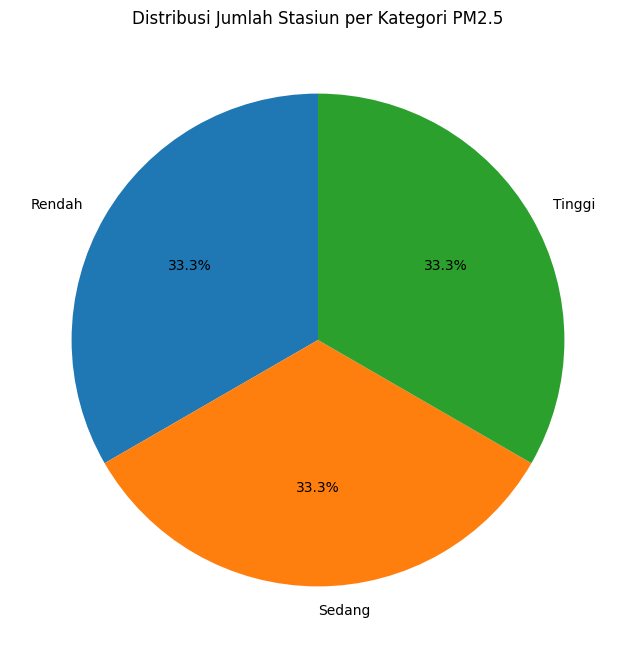

In [111]:
# Menghitung jumlah stasiun per kategori PM2.5
category_counts = prsa_klaster_padat_df.set_index("PM2.5-category")['station_count']

# Membuat pie chart
plt.figure(figsize=(8, 8))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Distribusi Jumlah Stasiun per Kategori PM2.5')
plt.ylabel('')  # Menghapus label 'PM2.5-category' yang tidak perlu
plt.show()


**Insight**

- Pembagian data dilakukan dengan binning kuantil, karena sebaran data bersifat skewed, sehingga pembagian data dengan interval yang sama panjang dapat mengakibatkan ukuran grup/klaster jauh berbeda
- Dari hasil pembagian kuantil rata-rata PM2.5, didapatkan 3 kelompok yaitu:
    - PM2.5 Rendah : Changping, Dingling, Huairou dan Shunyi
    - PM2.5 Sedang : Aotizhongxin, Guanyuan, Tiantan dan Wanliu
    - PM2.5 Tinggi : Dongsi, Gucheng, Nongzhanguan dan Wanshouxigong
- Dari hasil pembagian kuantil rata-rata PM10, didapatkan 3 kelompok yaitu:
    - PM10 Rendah : Changping, Dingling, Huairou dan Shunyi
    - PM10 Sedang : Aotizhongxin, Guanyuan, Nongzhanguan dan Tiantan 
    - PM10 Tinggi : Dongsi, Gucheng, Wanliu dan Wanshouxigong
    
- Anggota kedua klaster PM2.5 dan PM10 memiliki anggota yang sebagian besar sama, kecuali pada stasiun Nongzhanguan dan Wanliu, dimana pada PM2.5 Wanliu termasuk sedang, sedangkan di PM10 termasuk tinggi. Kejadian sebaliknya terjadi pada stasiun Nongzhanguan dimana PM2.5 tergolong tinggi sedangkan PM10 tergolong Sedang


### Pertanyaan 5

Bagaimana sebaran geografis dari polutan partikel padat?

In [127]:
# Inisialisasi geolocator
geolocator = Nominatim(user_agent="geoapi")

# Fungsi untuk mendapatkan koordinat dari nama stasiun
def get_coordinates(station_name):
    try:
        location = geolocator.geocode(station_name)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None  # Jika lokasi tidak ditemukan
    except Exception as e:
        print(f"Error with {station_name}: {e}")
        return None, None

# Mendapatkan koordinat untuk setiap stasiun dan menambahkannya ke DataFrame
pm25_pm10_mean_df_reset[['latitude', 'longitude']] = pm25_pm10_mean_df_reset['station'].apply(lambda x: pd.Series(get_coordinates(x)))

# Tambahkan sedikit delay untuk menghindari pembatasan jumlah permintaan dari layanan geocoding
time.sleep(1)

# Menampilkan hasil akhir
pm25_pm10_mean_df_reset


,index,station,PM2.5,PM10,PM2.5-category,PM10-category,latitude,longitude
0,0,Aotizhongxin,82.120075,109.588187,Sedang,Sedang,34.374734,109.016205
1,1,Changping,70.545694,94.281790,Rendah,Rendah,40.219646,116.225091
2,2,Dingling,65.434317,83.295585,Rendah,Rendah,40.162427,117.653096
3,3,Dongsi,85.655404,109.952923,Tinggi,Tinggi,39.929247,116.417731
4,4,Guanyuan,82.512914,108.778322,Sedang,Sedang,29.558719,112.007610
5,5,Gucheng,83.412651,118.646161,Tinggi,Tinggi,37.349035,115.964682
6,6,Huairou,69.011408,90.984486,Rendah,Rendah,40.315481,116.626028
7,7,Nongzhanguan,84.375713,108.690044,Tinggi,Sedang,39.943720,116.466225
8,8,Shunyi,78.853887,98.397308,Rendah,Rendah,40.148750,116.653875
9,9,Tiantan,81.717653,105.999934,Sedang,Sedang,39.887858,116.392896


In [131]:
#Karena Wanshouxigong tidak bisa didapatkan koordinatnya, maka dilakukan pencarian manual dengan menyesuaikan nama kotanya
# Mendapatkan koordinat untuk stasiun "Wanshou xigong"
latitude, longitude = get_coordinates("wanshou")

# Ubah Dataframe
pm25_pm10_mean_df_reset.loc[pm25_pm10_mean_df_reset['station'] == 'Wanshouxigong', ['latitude', 'longitude']] = latitude, longitude

# Menambahkan sedikit delay untuk menghindari pembatasan jumlah permintaan dari layanan geocoding
time.sleep(1)

# Menampilkan hasil akhir
pm25_pm10_mean_df_reset



,index,station,PM2.5,PM10,PM2.5-category,PM10-category,latitude,longitude
0,0,Aotizhongxin,82.120075,109.588187,Sedang,Sedang,34.374734,109.016205
1,1,Changping,70.545694,94.281790,Rendah,Rendah,40.219646,116.225091
2,2,Dingling,65.434317,83.295585,Rendah,Rendah,40.162427,117.653096
3,3,Dongsi,85.655404,109.952923,Tinggi,Tinggi,39.929247,116.417731
4,4,Guanyuan,82.512914,108.778322,Sedang,Sedang,29.558719,112.007610
5,5,Gucheng,83.412651,118.646161,Tinggi,Tinggi,37.349035,115.964682
6,6,Huairou,69.011408,90.984486,Rendah,Rendah,40.315481,116.626028
7,7,Nongzhanguan,84.375713,108.690044,Tinggi,Sedang,39.943720,116.466225
8,8,Shunyi,78.853887,98.397308,Rendah,Rendah,40.148750,116.653875
9,9,Tiantan,81.717653,105.999934,Sedang,Sedang,39.887858,116.392896


In [135]:

# Membuat kolom 'geometry' yang berisi objek Point dari koordinat (longitude, latitude)
geometry = [Point(lon, lat) for lon, lat in zip(pm25_pm10_mean_df_reset['longitude'], pm25_pm10_mean_df_reset['latitude'])]

# Membuat GeoDataFrame
gdf = gpd.GeoDataFrame(pm25_pm10_mean_df_reset, geometry=geometry)

# Tentukan sistem koordinat (CRS), misalnya EPSG:4326 untuk WGS84
gdf.set_crs('EPSG:4326', allow_override=True, inplace=True)


,index,station,PM2.5,PM10,PM2.5-category,PM10-category,latitude,longitude,geometry
0,0,Aotizhongxin,82.120075,109.588187,Sedang,Sedang,34.374734,109.016205,POINT (109.0162 34.37473)
1,1,Changping,70.545694,94.281790,Rendah,Rendah,40.219646,116.225091,POINT (116.22509 40.21965)
2,2,Dingling,65.434317,83.295585,Rendah,Rendah,40.162427,117.653096,POINT (117.6531 40.16243)
3,3,Dongsi,85.655404,109.952923,Tinggi,Tinggi,39.929247,116.417731,POINT (116.41773 39.92925)
4,4,Guanyuan,82.512914,108.778322,Sedang,Sedang,29.558719,112.007610,POINT (112.00761 29.55872)
5,5,Gucheng,83.412651,118.646161,Tinggi,Tinggi,37.349035,115.964682,POINT (115.96468 37.34903)
6,6,Huairou,69.011408,90.984486,Rendah,Rendah,40.315481,116.626028,POINT (116.62603 40.31548)
7,7,Nongzhanguan,84.375713,108.690044,Tinggi,Sedang,39.943720,116.466225,POINT (116.46623 39.94372)
8,8,Shunyi,78.853887,98.397308,Rendah,Rendah,40.148750,116.653875,POINT (116.65387 40.14875)
9,9,Tiantan,81.717653,105.999934,Sedang,Sedang,39.887858,116.392896,POINT (116.3929 39.88786)


In [150]:
# Menggabungkan dataframe data asli yang bersih dengan data koordinat

# Merge dua DataFrame
merged_df = pd.merge(
    prsa_df, 
    gdf[['station', 'latitude', 'longitude','geometry']],  # Mengambil hanya kolom yang dibutuhkan
    on='station',  # Menggabungkan berdasarkan kolom 'station'
    how='left'     # Menggunakan left join agar semua baris di prsa_df disertakan
)

# Menyimpan hasil ke dalam file csv
merged_df.to_csv('all_data_cleaned.csv', index=False)

# Menampilkan hasil
merged_df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,latitude,longitude,geometry
0,1,2013,3,1,0,6.0,18.0,5.0,50.0,800.0,...,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng,37.349035,115.964682,POINT (115.96468 37.34903)
1,2,2013,3,1,1,6.0,15.0,5.0,50.0,800.0,...,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng,37.349035,115.964682,POINT (115.96468 37.34903)
2,3,2013,3,1,2,5.0,18.0,7.0,50.0,700.0,...,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng,37.349035,115.964682,POINT (115.96468 37.34903)
3,4,2013,3,1,3,6.0,20.0,6.0,50.0,900.0,...,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng,37.349035,115.964682,POINT (115.96468 37.34903)
4,5,2013,3,1,4,5.0,17.0,5.0,50.0,600.0,...,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng,37.349035,115.964682,POINT (115.96468 37.34903)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,27.0,72.0,8.0,92.0,800.0,...,10.3,1014.2,-12.4,0.0,W,1.8,Shunyi,40.148750,116.653875,POINT (116.65387 40.14875)
420764,35061,2017,2,28,20,47.0,55.0,17.0,86.0,1100.0,...,9.8,1014.5,-9.9,0.0,NW,1.5,Shunyi,40.148750,116.653875,POINT (116.65387 40.14875)
420765,35062,2017,2,28,21,18.0,28.0,4.0,30.0,500.0,...,9.1,1014.6,-12.7,0.0,NE,1.7,Shunyi,40.148750,116.653875,POINT (116.65387 40.14875)
420766,35063,2017,2,28,22,18.0,20.0,9.0,33.0,500.0,...,7.1,1015.2,-13.2,0.0,WNW,1.8,Shunyi,40.148750,116.653875,POINT (116.65387 40.14875)


In [160]:
# Menghitung jumlah unik stasiun dan rata-rata keseluruhan untuk setiap kolom
total_unique_stations = prsa_df['station'].nunique()
avg_all_data = prsa_df[['PM2.5', 'PM10', 'CO', 'SO2', 'NO2', 'O3']].mean()

# Menambahkan baris yang berisi rata-rata seluruh data
global_avg = pd.DataFrame({
    'station_count': [total_unique_stations], 
    'avg_PM2_5': [avg_all_data['PM2.5']], 
    'avg_PM10': [avg_all_data['PM10']], 
    'avg_CO': [avg_all_data['CO']], 
    'avg_SO2': [avg_all_data['SO2']], 
    'avg_NO2': [avg_all_data['NO2']], 
    'avg_O3': [avg_all_data['O3']]
})


global_avg

,station_count,avg_PM2_5,avg_PM10,avg_CO,avg_SO2,avg_NO2,avg_O3
0,12,79.273026,104.235659,1212.909829,15.642997,50.384959,56.925748


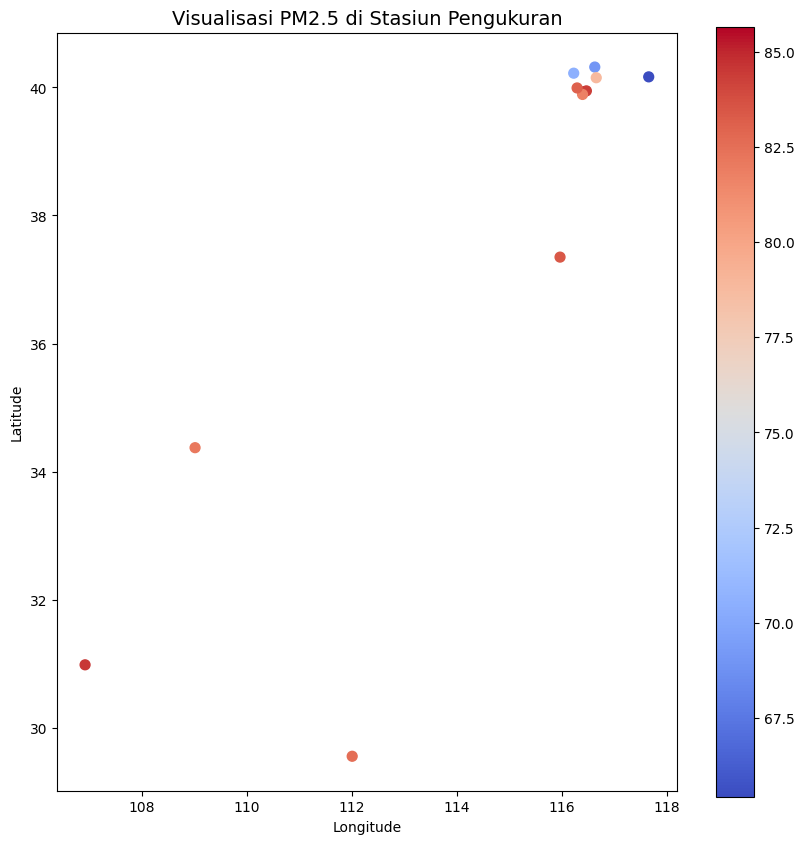

In [137]:
# Menggambarkan nilai PM2.5 dalam bidang koordinat bumi
ax = gdf.plot(column='PM2.5', cmap='coolwarm', legend=True, figsize=(10, 10), markersize=50)

# Menambahkan label nama stasiun di atas titik
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, ""): #gdf['station']
    ax.text(x, y, label, fontsize=9, ha='right')

# Menambahkan judul dan label
ax.set_title('Visualisasi PM2.5 di Stasiun Pengukuran', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


**Insight**

- Dilihat dari heatmap, maka PM2.5 cenderung rendah di area yang makin ke arah utara garis khatulistiwa (latitude makin tinggi)
- Untuk longitude, tidak tampak sebuah pengaruh yang jelas.

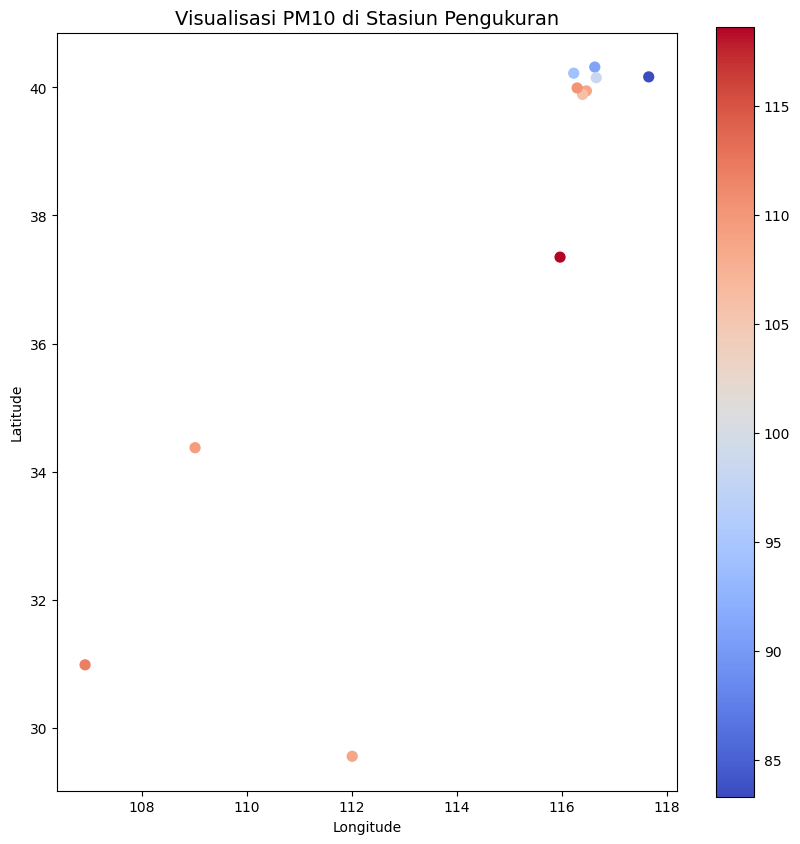

In [140]:
# Menggambarkan nilai PM10 dalam bidang koordinat bumi
ax = gdf.plot(column='PM10', cmap='coolwarm', legend=True, figsize=(10, 10), markersize=50)

# Menambahkan label nama stasiun di atas titik
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, ""): #gdf['station']
    ax.text(x, y, label, fontsize=9, ha='right')

# Menambahkan judul dan label
ax.set_title('Visualisasi PM10 di Stasiun Pengukuran', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


**Insight**

- Dilihat dari heatmap, maka PM10 cenderung rendah di area yang makin ke arah utara garis khatulistiwa (latitude makin tinggi)
- Untuk longitude, tidak tampak sebuah pengaruh yang jelas.
- Hal ini hampir sama dengan grafik PM2.5, dimana memang PM2.5 dan PM10 memiliki korelasi positif yang baik

In [143]:
# Membuat peta dasar di koordinat tengah dari dataset
peta = folium.Map(location=[pm25_pm10_mean_df_reset['latitude'].mean(), pm25_pm10_mean_df_reset['longitude'].mean()], zoom_start=6)

# Menambahkan MarkerCluster untuk stasiun
marker_cluster = MarkerCluster().add_to(peta)

# Menambahkan marker untuk setiap stasiun dengan popup yang menampilkan PM2.5 dan PM10
for _, row in pm25_pm10_mean_df_reset.iterrows():
    folium.Marker([row['latitude'], row['longitude']], 
                  popup=f"{row['station']}: PM2.5 = {row['PM2.5']} µg/m³, PM10 = {row['PM10']} µg/m³").add_to(marker_cluster)

heat_data = [[row['latitude'], row['longitude'], row['PM2.5']] for index, row in pm25_pm10_mean_df_reset.iterrows()]
HeatMap(heat_data, cmap='coolwarm', radius=15).add_to(peta)

# Menampilkan peta dalam notebook
display(peta)

**Insight**

- Penggambaran peta di atas dimaksudkan untuk memberikan visualisasi secara geografis untuk lebih mudah melihat lokasi area.
- Adanya nilai angka menunjukkan beberapa area berdekatan yang bisa dilihat lebih detail dengan cara menekan nomor angka tersebut.
- Jika sebuah lokasi diklik maka nilai PM2.5 dan PM10 akan ditampilkan berupa popup
- Jika peta di atas diperbesar maka akan semakin tampak jelas bahwa semakin ke utara posisi stasiun maka nilai PM2.5 semakin rendah (semakin minim polusi)

## Conclusion

### Korelasi antar kolom data

**1. Korelasi Positif PM2.5**
- Kolom PM2.5 menunjukkan korelasi positif yang kuat (≥ 0.5) dengan PM10, NO2, dan CO. Ini berarti bahwa semakin tinggi nilai PM2.5, maka nilai PM10, NO2, dan CO juga cenderung meningkat.

**2. Korelasi Positif TEMP**
- Kolom TEMP memiliki korelasi positif (≥ 0.5) dengan O3 dan DEWP, yang berarti semakin tinggi nilai O3, maka suhu (TEMP) dan kelembapan titik embun (DEWP) juga cenderung meningkat.

**3. Korelasi Negatif TEMP dengan PRES**
- Kolom TEMP memiliki korelasi negatif dengan PRES. Ini menunjukkan bahwa ketika suhu (TEMP) meningkat, tekanan atmosfer (PRES) cenderung menurun.

**4. Tidak Ada Korelasi untuk RAIN dan WSPM**
- Kolom RAIN dan WSPM tidak menunjukkan korelasi yang signifikan dengan kolom lainnya, yang berarti perubahan pada kedua variabel ini tidak berhubungan langsung dengan variabel lainnya dalam dataset ini.

### Analisis Konsentrasi Partikel Padat PM2.5 dan PM10 pada Stasiun Pengamatan
**1. Konsentrasi PM2.5**
- Dongsi memiliki konsentrasi PM2.5 tertinggi, sedangkan Dingling terendah.
- Konsentrasi PM2.5 di Dongsi, Wanshouxigong, dan Nongzhanguan hampir sama.

**2. Konsentrasi PM10**
- Secara umum, PM10 lebih tinggi dari PM2.5 di semua stasiun.
- Gucheng memiliki PM10 tertinggi, sementara Dingling terendah.
- Dingling adalah stasiun dengan polusi paling rendah berdasarkan kedua polutan.

**3. Tren Tahunan**
- PM2.5 dan PM10 cenderung naik pada 2017 setelah penurunan pada 2016.
- Dingling menunjukkan penurunan PM2.5 yang paling rendah pada 2017, sementara Wanliu mengalami peningkatan PM10 drastis pada 2014 meski PM2.5 sedikit turun.

**4. Waktu Tertinggi dan Terendah**
- PM2.5 tinggi antara 18.00–05.00, rendah antara 07.00–17.00 di sebagian besar stasiun, kecuali Dingling.
- PM10 tertinggi antara 17.00–04.00, terendah antara 05.00–07.00 dan 12.00–15.00.

**5. Konsentrasi Bulanan PM2.5**
- PM2.5 paling rendah terjadi setiap Juli, kecuali pada 2014, di mana Mei tercatat sebagai bulan terendah.

### Analisis Konsentrasi Gas di Berbagai Stasiun Pengamatan

**1. Konsentrasi Gas CO**
- Konsentrasi CO tertinggi terdapat di Dongsi dan terendah di Dingling.

**2. Konsentrasi Gas NO2**
- Konsentrasi NO2 rata-rata tertinggi terpantau di Wanliu, sementara yang terendah ada di Dingling.

**3. Konsentrasi Gas SO2**
- Gas SO2 memiliki konsentrasi rata-rata tertinggi di Huairou dan terendah di Dingling.

**4. Konsentrasi Gas O3**
- Konsentrasi O3 tertinggi tercatat di Dingling, sedangkan yang terendah ada di Wanliu.

### Klasterisasi Stasiun dengan Kuantil Binning Partikel Padat

**1. Hasil Pembagian Kuantil untuk PM2.5**
- PM2.5 Rendah: Changping, Dingling, Huairou, dan Shunyi
- PM2.5 Sedang: Aotizhongxin, Guanyuan, Tiantan, dan Wanliu
- PM2.5 Tinggi: Dongsi, Gucheng, Nongzhanguan, dan Wanshouxigong

**2. Hasil Pembagian Kuantil untuk PM10**
- PM10 Rendah: Changping, Dingling, Huairou, dan Shunyi
- PM10 Sedang: Aotizhongxin, Guanyuan, Nongzhanguan, dan Tiantan
- PM10 Tinggi: Dongsi, Gucheng, Wanliu, dan Wanshouxigong


### Analisis Geografis Partikel Padat

**1. Korelasi dengan Latitude (Garisan Lintang)**
- Dari heatmap, terlihat bahwa PM2.5 dan PM10 cenderung lebih rendah di daerah yang semakin ke utara garis khatulistiwa (latitude semakin tinggi).
- Hal ini menunjukkan bahwa polusi udara, khususnya PM2.5 dan PM10, menurun seiring dengan peningkatan latitude.

**2. Korelasi dengan Longitude (Garisan Bujur)**
- Tidak ada pengaruh yang jelas terlihat antara longitude dan konsentrasi PM2.5 atau PM10.